# Génération Augmentée par Récupération (RAG)

Mistral AI excelle dans un large éventail de tâches, mais peut rencontrer des difficultés avec des requêtes spécifiques à votre contexte d'entreprise unique. C'est là que la Génération Augmentée par Récupération (RAG) devient inestimable. Le RAG permet à Mistral d'exploiter vos bases de connaissances internes ou vos documents d'assistance client, améliorant considérablement sa capacité à répondre aux questions spécifiques à votre domaine. Les entreprises construisent de plus en plus d'applications RAG pour améliorer leurs processus dans le support client, les questions-réponses sur les documents internes de l'entreprise, l'analyse financière et juridique, et bien plus encore.

Dans ce guide, nous allons vous montrer comment construire et optimiser un système RAG en utilisant une documentation comme base de connaissances. Nous vous guiderons à travers :

1) La mise en place d'un système RAG de base utilisant une base de données vectorielle en mémoire et des embeddings de Mistral AI.

2) La construction d'une suite d'évaluation robuste. Nous irons au-delà des évaluations basées sur les "vibrations" et vous montrerons comment mesurer indépendamment les performances du pipeline de récupération et les performances de bout en bout.

3) L'implémentation de techniques avancées pour améliorer le RAG, y compris l'indexation des résumés et le re-classement avec Mistral AI.

Grâce à une série d'améliorations ciblées, nous pouvons réaliser des gains de performance significatifs sur les métriques suivantes par rapport à un pipeline RAG de base (nous expliquerons ce que toutes ces métriques *signifient* un peu plus tard) :

- Précision moyenne : 0.43 --> 0.44
- Rappel moyen : 0.66 --> 0.69
- Score F1 moyen : 0.52 --> 0.54
- Rang Réciproque Moyen (MRR) : 0.74 --> 0.87
- Précision de bout en bout : 71% --> 81%

#### Remarque :

Les évaluations dans ce guide sont conçues pour refléter un système d'évaluation en production, et vous devez garder à l'esprit qu'elles peuvent prendre du temps à s'exécuter. Envisagez de sauter l'évaluation complète de bout en bout si vous essayez de conserver l'utilisation des tokens.

## Table des matières

1) Configuration

2) Niveau 1 - RAG de base

3) Construction d'un système d'évaluation

4) Niveau 2 - Indexation des résumés

5) Niveau 3 - Indexation des résumés et re-classement

## Configuration

Nous aurons besoin de quelques bibliothèques, notamment :

1) `mistralai` - pour interagir avec les modèles de Mistral AI et générer des embeddings

2) `pandas`, `numpy`, `matplotlib`, et `scikit-learn` pour la manipulation et la visualisation des données

3) `python-dotenv` - pour charger les clés API à partir du fichier .env

Vous aurez besoin d'une clé API de [Mistral AI](https://mistral.ai/) stockée dans un fichier .env

In [22]:
## setup

%pip install mistralai --upgrade
%pip install python-dotenv --upgrade
%pip install pandas
%pip install numpy
%pip install matplotlib
%pip install seaborn
%pip install -U scikit-learn
%pip install tqdm
%pip install PyPDF2
%pip install langchain
%pip install nltk

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
  Using ca

In [23]:

# Configuration de l'API Mistral avec le nouveau client (version 1.0.0+)
import os
from dotenv import load_dotenv
from mistralai import Mistral

# Vérifier la présence du fichier .env
if not os.path.exists(".env"):
    print("❌ Le fichier .env est introuvable à la racine du projet.")
    print("Créez un fichier .env avec la ligne suivante :")
    print("MISTRAL_API_KEY=sk-xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx")
else:
    load_dotenv()

def get_mistral_client():
    """Fonction pour initialiser le client Mistral AI de manière sécurisée"""
    api_key = os.getenv("MISTRAL_API_KEY")
    if not api_key:
        raise ValueError(
            "MISTRAL_API_KEY non trouvée. "
            "Vérifiez que votre fichier .env contient cette variable et relancez le kernel."
        )
    
    print(f"Clé API Mistral trouvée: {api_key[:8]}...")  # Afficher seulement les premiers caractères
    return Mistral(api_key=api_key)

# Utiliser notre configuration sécurisée depuis le fichier .env
client = get_mistral_client()
print("✅ Configuration Mistral AI (nouveau client) chargée avec succès depuis le fichier .env")

Clé API Mistral trouvée: LjNuPnNR...
✅ Configuration Mistral AI (nouveau client) chargée avec succès depuis le fichier .env


### Initialisation d'une classe de base de données vectorielle

Dans cet exemple, nous utilisons une base de données vectorielle en mémoire, mais pour une application en production, vous pourriez préférer utiliser une solution hébergée.

In [24]:
import os
import pickle
import json
import numpy as np
from mistralai import Mistral

class VectorDB:
    def __init__(self, name, api_key=None):
        if api_key is None:
            api_key = os.getenv("MISTRAL_API_KEY")
        self.client = Mistral(api_key=api_key)
        self.name = name
        self.embeddings = []
        self.metadata = []
        self.query_cache = {}
        self.db_path = f"./data/{name}/vector_db.pkl"

    def load_data(self, data):
        if self.embeddings and self.metadata:
            print("Vector database is already loaded. Skipping data loading.")
            return
        if os.path.exists(self.db_path):
            print("Loading vector database from disk.")
            self.load_db()
            return

        texts = [f"Heading: {item['chunk_heading']}\n\n Chunk Text:{item['text']}" for item in data]
        self._embed_and_store(texts, data)
        self.save_db()
        print("Vector database loaded and saved.")

    def _embed_and_store(self, texts, data):
        batch_size = 16  # Mistral a généralement des limites de batch plus petites
        embeddings = []
        
        # Traitement par lots
        for i in range(0, len(texts), batch_size):
            batch_texts = texts[i:i + batch_size]
            batch_embeddings = []
            for text in batch_texts:
                try:
                    # Utiliser correctement l'API Mistral pour les embeddings avec SDK 1.8.2
                    response = self.client.embeddings.create(
                        model="mistral-embed",
                        inputs=[text]
                    )
                    embedding = response.data[0].embedding
                    batch_embeddings.append(embedding)
                except Exception as e:
                    print(f"Error embedding text: {e}")
                    # Fallback to zeros
                    batch_embeddings.append([0.0] * 1024)  # Mistral embeddings are typically 1024 dim
            embeddings.extend(batch_embeddings)
            
        self.embeddings = embeddings
        self.metadata = data

    def search(self, query, k=5, similarity_threshold=0.75):
        if query in self.query_cache:
            query_embedding = self.query_cache[query]
        else:
            try:
                # Utiliser correctement l'API Mistral pour les embeddings avec SDK 1.8.2
                response = self.client.embeddings.create(
                    model="mistral-embed",
                    inputs=[query]
                )
                query_embedding = response.data[0].embedding
                self.query_cache[query] = query_embedding
            except Exception as e:
                print(f"Error retrieving query embedding: {e}")
                return []

        if not self.embeddings:
            raise ValueError("No data loaded in the vector database.")

        similarities = np.dot(self.embeddings, query_embedding)
        top_indices = np.argsort(similarities)[::-1]
        top_examples = []
        
        for idx in top_indices:
            if similarities[idx] >= similarity_threshold:
                example = {
                    "metadata": self.metadata[idx],
                    "similarity": similarities[idx],
                }
                top_examples.append(example)
                
                if len(top_examples) >= k:
                    break
        self.save_db()
        return top_examples

    def save_db(self):
        data = {
            "embeddings": self.embeddings,
            "metadata": self.metadata,
            "query_cache": json.dumps(self.query_cache),
        }
        os.makedirs(os.path.dirname(self.db_path), exist_ok=True)
        with open(self.db_path, "wb") as file:
            pickle.dump(data, file)

    def load_db(self):
        if not os.path.exists(self.db_path):
            raise ValueError("Vector database file not found. Use load_data to create a new database.")
        with open(self.db_path, "rb") as file:
            data = pickle.load(file)
        self.embeddings = data["embeddings"]
        self.metadata = data["metadata"]
        self.query_cache = json.loads(data["query_cache"])

## Niveau 1 - RAG de base

Pour commencer, nous allons mettre en place un pipeline RAG de base en utilisant une approche minimaliste. C'est ce que beaucoup dans l'industrie appellent parfois 'RAG Naïf'. Un pipeline RAG de base comprend les 3 étapes suivantes :

1) Découper les documents par titre - contenant uniquement le contenu de chaque sous-titre

2) Encoder chaque document sous forme d'embedding

3) Utiliser la similarité cosinus pour récupérer les documents afin de répondre à la requête

In [25]:
import json
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET
from tqdm import tqdm
import logging
import time
import random
from typing import Callable, List, Dict, Any, Tuple, Set
from mistralai import Mistral

# Load the evaluation dataset
with open('evaluation/docs_evaluation_dataset.json', 'r') as f:
    eval_data = json.load(f)

# Load the documentation
with open('data/anthropic_docs.json', 'r') as f:
    docs = json.load(f)

# Initialize the VectorDB
db = VectorDB("docs")
db.load_data(docs)

def retrieve_base(query, db):
    results = db.search(query, k=3)
    context = ""
    for result in results:
        chunk = result['metadata']
        context += f"\n{chunk['text']}\n"
    return results, context

def answer_query_base(query, db, max_retries=3, initial_retry_delay=1):
    """
    Génère une réponse à une requête en utilisant la base de données vectorielle.
    Inclut un mécanisme de gestion des erreurs de limite de débit.
    
    Args:
        query: La requête à traiter
        db: La base de données vectorielle
        max_retries: Le nombre maximal de tentatives en cas d'erreur de limite de débit
        initial_retry_delay: Le délai initial avant de réessayer (en secondes)
        
    Returns:
        La réponse générée
    """
    documents, context = retrieve_base(query, db)
    prompt = f"""
    You have been tasked with helping us to answer the following query: 
    <query>
    {query}
    </query>
    You have access to the following documents which are meant to provide context as you answer the query:
    <documents>
    {context}
    </documents>
    Please remain faithful to the underlying context, and only deviate from it if you are 100% sure that you know the answer already. 
    Answer the question now, and avoid providing preamble such as 'Here is the answer', etc
    """
    
    # Gestion des erreurs de limite de débit
    retry_count = 0
    retry_delay = initial_retry_delay
    
    while retry_count <= max_retries:
        try:
            # Utiliser la bonne syntaxe pour le SDK Mistral version 1.8.2
            response = client.chat.complete(
                model="mistral-small-latest",
                messages=[
                    {"role": "user", "content": prompt}
                ],
                temperature=0
            )
            
            return response.choices[0].message.content
        
        except Exception as e:
            error_message = str(e).lower()
            if "rate limit" in error_message or "429" in error_message:
                retry_count += 1
                if retry_count > max_retries:
                    print(f"Maximum retries reached. Returning error message.")
                    return f"Erreur: Limite de débit dépassée après {max_retries} tentatives."
                
                # Utiliser un délai exponentiel avec une composante aléatoire
                jitter = random.uniform(0.8, 1.2)
                sleep_time = retry_delay * jitter
                print(f"Rate limit exceeded. Waiting {sleep_time:.2f}s before retry {retry_count}/{max_retries}")
                time.sleep(sleep_time)
                retry_delay *= 2  # Backoff exponentiel
            else:
                print(f"Unexpected error: {e}")
                return f"Erreur lors de la génération de la réponse: {str(e)}"

Loading vector database from disk.



## Configuration de l'évaluation

Lors de l'évaluation des applications RAG, il est essentiel d'évaluer séparément les performances du système de récupération et du système de bout en bout.

Nous avons généré synthétiquement un ensemble de données d'évaluation composé de 100 échantillons qui comprennent les éléments suivants :
- Une question
- Des fragments de nos documents qui sont pertinents pour cette question. C'est ce que nous attendons de notre système de récupération lorsque la question est posée
- Une réponse correcte à la question.

Il s'agit d'un ensemble de données relativement difficile. Certaines de nos questions nécessitent une synthèse entre plusieurs fragments pour y répondre correctement, il est donc important que notre système puisse charger plus d'un fragment à la fois. Vous pouvez examiner l'ensemble de données en ouvrant `evaluation/docs_evaluation_dataset.json`

Exécutez la cellule suivante pour voir un aperçu de l'ensemble de données

In [26]:
#previewing our eval dataset
import json

def preview_json(file_path, num_items=3):
    try:
        with open(file_path, 'r') as file:
            data = json.load(file)
            
        if isinstance(data, list):
            preview_data = data[:num_items]
        elif isinstance(data, dict):
            preview_data = dict(list(data.items())[:num_items])
        else:
            print(f"Unexpected data type: {type(data)}. Cannot preview.")
            return
        
        print(f"Preview of the first {num_items} items from {file_path}:")
        print(json.dumps(preview_data, indent=2))
        print(f"\nTotal number of items: {len(data)}")
        
    except FileNotFoundError:
        print(f"File not found: {file_path}")
    except json.JSONDecodeError:
        print(f"Invalid JSON in file: {file_path}")
    except Exception as e:
        print(f"An error occurred: {str(e)}")

preview_json('evaluation/docs_evaluation_dataset.json')

Preview of the first 3 items from evaluation/docs_evaluation_dataset.json:
[
  {
    "id": "efc09699",
    "question": "How can you create multiple test cases for an evaluation in the Anthropic Evaluation tool?",
    "correct_chunks": [
      "https://docs.anthropic.com/en/docs/test-and-evaluate/eval-tool#creating-test-cases",
      "https://docs.anthropic.com/en/docs/build-with-claude/develop-tests#building-evals-and-test-cases"
    ],
    "correct_answer": "To create multiple test cases in the Anthropic Evaluation tool, click the 'Add Test Case' button, fill in values for each variable in your prompt, and repeat the process to create additional test case scenarios."
  },
  {
    "id": "1305ea00",
    "question": "What embeddings provider does Anthropic recommend for customized domain-specific models, and what capabilities does this provider offer?",
    "correct_chunks": [
      "https://docs.anthropic.com/en/docs/build-with-claude/embeddings#before-implementing-embeddings",
      "h

# Définitions des métriques
Nous évaluerons notre système sur la base de 5 métriques clés : Précision, Rappel, Score F1, Rang Réciproque Moyen (MRR) et Précision de bout en bout.

## Métriques de récupération :

### Précision
La précision représente la proportion de fragments récupérés qui sont réellement pertinents. Elle répond à la question : "Parmi les fragments que nous avons récupérés, combien étaient corrects ?"

Points clés :
- Une précision élevée indique un système efficace avec peu de faux positifs.
- Une faible précision suggère que de nombreux fragments non pertinents sont récupérés.
- Notre système récupère un minimum de 3 fragments par requête, ce qui peut affecter les scores de précision.

Formule :
$$
\text{Précision} = \frac{\text{Vrais Positifs}}{\text{Total Récupéré}} = \frac{|\text{Récupéré} \cap \text{Correct}|}{|\text{Récupéré}|}
$$

### Rappel
Le rappel mesure l'exhaustivité de notre système de récupération. Il répond à la question : "De tous les fragments corrects qui existent, combien avons-nous réussi à récupérer ?"

Points clés :
- Un rappel élevé indique une couverture complète des informations nécessaires.
- Un faible rappel suggère que des fragments importants sont manqués.
- Le rappel est crucial pour garantir que le LLM a accès à toutes les informations nécessaires.

Formule :
$$
\text{Rappel} = \frac{\text{Vrais Positifs}}{\text{Total Correct}} = \frac{|\text{Récupéré} \cap \text{Correct}|}{|\text{Correct}|}
$$

### Score F1
Le score F1 fournit une mesure équilibrée entre la précision et le rappel. Il est particulièrement utile lorsque vous avez besoin d'une seule métrique pour évaluer les performances du système, en particulier avec des distributions de classes inégales.

Points clés :
- Le score F1 varie de 0 à 1, 1 représentant une précision et un rappel parfaits.
- C'est la moyenne harmonique de la précision et du rappel, tendant vers la valeur la plus basse des deux.
- Utile dans les scénarios où les faux positifs et les faux négatifs sont importants.

Formule :
$$
\text{Score F1} = 2 \times \frac{\text{Précision} \times \text{Rappel}}{\text{Précision} + \text{Rappel}}
$$

Interprétation du score F1 :
- Un score F1 de 1.0 indique une précision et un rappel parfaits.
- Un score F1 de 0.0 indique la pire performance.
- En général, plus le score F1 est élevé, meilleures sont les performances globales.

### Équilibrer Précision, Rappel et Score F1 :
- Il y a souvent un compromis entre précision et rappel.
- La récupération minimale de fragments de notre système favorise le rappel par rapport à la précision.
- L'équilibre optimal dépend du cas d'utilisation spécifique.
- Dans de nombreux systèmes RAG, un rappel élevé est souvent prioritaire, car les LLM peuvent filtrer les informations moins pertinentes pendant la génération.

### Rang Réciproque Moyen (MRR) @k
Le MRR mesure à quel point notre système classe bien les informations pertinentes. Il nous aide à comprendre la rapidité avec laquelle un utilisateur trouverait ce qu'il cherche s'il commençait par le haut de nos résultats récupérés.

Points clés :
- Le MRR varie de 0 à 1, où 1 est parfait (la réponse correcte est toujours en premier).
- Il ne considère que le rang du premier résultat correct pour chaque requête.
- Un MRR plus élevé indique un meilleur classement des informations pertinentes.

Formule :
$$
\text{MRR} = \frac{1}{|Q|} \sum_{i=1}^{|Q|} \frac{1}{\text{rang}_i}
$$

Où :
- |Q| est le nombre total de requêtes
- rang_i est la position du premier élément pertinent pour la i-ème requête

## Métriques de bout en bout :

### Précision de bout en bout
Nous utilisons un LLM comme juge (Mistral Small) pour évaluer si la réponse générée est correcte en fonction de la question et de la réponse de référence.

Formule :
$$
\text{Précision de bout en bout} = \frac{\text{Nombre de réponses correctes}}{\text{Nombre total de questions}}
$$

Cette métrique évalue l'ensemble du pipeline, de la récupération à la génération de réponses.

## Définition de nos fonctions de calcul des métriques

In [27]:
def calculate_mrr(retrieved_links: List[str], correct_links: Set[str]) -> float:
    for i, link in enumerate(retrieved_links, 1):
        if link in correct_links:
            return 1 / i
    return 0

def evaluate_retrieval(retrieval_function: Callable, evaluation_data: List[Dict[str, Any]], db: Any) -> Tuple[float, float, float, float, List[float], List[float], List[float]]:
    precisions = []
    recalls = []
    mrrs = []
    
    for i, item in enumerate(tqdm(evaluation_data, desc="Evaluating Retrieval")):
        try:
            retrieved_chunks, _ = retrieval_function(item['question'], db)
            retrieved_links = [chunk['metadata'].get('chunk_link', chunk['metadata'].get('url', '')) for chunk in retrieved_chunks]
        except Exception as e:
            logging.error(f"Error in retrieval function: {e}")
            continue

        correct_links = set(item['correct_chunks'])
        
        true_positives = len(set(retrieved_links) & correct_links)
        precision = true_positives / len(retrieved_links) if retrieved_links else 0
        recall = true_positives / len(correct_links) if correct_links else 0
        mrr = calculate_mrr(retrieved_links, correct_links)
        
        precisions.append(precision)
        recalls.append(recall)
        mrrs.append(mrr)
        
        if (i + 1) % 10 == 0:
            print(f"Processed {i + 1}/{len(evaluation_data)} items. Current Avg Precision: {sum(precisions) / len(precisions):.4f}, Avg Recall: {sum(recalls) / len(recalls):.4f}, Avg MRR: {sum(mrrs) / len(mrrs):.4f}")
    
    avg_precision = sum(precisions) / len(precisions) if precisions else 0
    avg_recall = sum(recalls) / len(recalls) if recalls else 0
    avg_mrr = sum(mrrs) / len(mrrs) if mrrs else 0
    f1 = 2 * (avg_precision * avg_recall) / (avg_precision + avg_recall) if (avg_precision + avg_recall) > 0 else 0
    
    return avg_precision, avg_recall, avg_mrr, f1, precisions, recalls, mrrs

import time
import random

def evaluate_end_to_end(answer_query_function, db, eval_data, max_retries=5, initial_retry_delay=1):
    """
    Évalue les performances du modèle RAG de bout en bout.
    
    Args:
        answer_query_function: Fonction qui génère une réponse à partir d'une requête et d'une base de données
        db: Base de données vectorielle
        eval_data: Données d'évaluation
        max_retries: Nombre maximum de tentatives en cas d'erreur de limite de débit
        initial_retry_delay: Délai initial avant de réessayer (en secondes)
        
    Returns:
        Un tuple (précision, liste des résultats)
    """
    correct_answers = 0
    results = []
    total_questions = len(eval_data)
    
    # Pour sauvegarde partielle en cas d'arrêt
    partial_results_file = "partial_e2e_results.json"
    completed_indices = set()
    
    # Vérifier si des résultats partiels existent déjà
    try:
        with open(partial_results_file, 'r') as f:
            partial_data = json.load(f)
            results = partial_data.get("results", [])
            completed_indices = set(partial_data.get("completed_indices", []))
            correct_answers = sum(results)
            print(f"Loaded {len(results)} existing results. Continuing from where we left off.")
    except (FileNotFoundError, json.JSONDecodeError):
        pass
    
    for i, item in enumerate(tqdm(eval_data, desc="Evaluating End-to-End")):
        # Sauter les éléments déjà traités
        if i in completed_indices:
            continue
            
        query = item['question']
        correct_answer = item['correct_answer']
        
        # Obtenir la réponse générée avec gestion des erreurs de limite de débit
        retry_count = 0
        retry_delay = initial_retry_delay
        while retry_count <= max_retries:
            try:
                generated_answer = answer_query_function(query, db)
                break  # Sortir de la boucle si l'appel réussit
            except Exception as e:
                error_message = str(e).lower()
                if "rate limit" in error_message or "429" in error_message:
                    retry_count += 1
                    if retry_count > max_retries:
                        print(f"Maximum retries reached for query {i}. Skipping.")
                        generated_answer = "ERROR: Rate limit exceeded"
                        break
                    
                    # Utiliser un délai exponentiel avec une composante aléatoire pour éviter les collisions
                    jitter = random.uniform(0.8, 1.2)
                    sleep_time = retry_delay * jitter
                    print(f"Rate limit exceeded. Waiting {sleep_time:.2f}s before retry {retry_count}/{max_retries}")
                    time.sleep(sleep_time)
                    retry_delay *= 2  # Backoff exponentiel
                else:
                    print(f"Unexpected error: {e}")
                    generated_answer = f"ERROR: {str(e)}"
                    break
        
        prompt = f"""
        You are an AI assistant tasked with evaluating the correctness of answers to questions about documentation.
        
        Question: {query}
        
        Correct Answer: {correct_answer}
        
        Generated Answer: {generated_answer}
        
        Is the Generated Answer correct based on the Correct Answer? You should pay attention to the substance of the answer, and ignore minute details that may differ. 
        
        Small differences or changes in wording don't matter. If the generated answer and correct answer are saying essentially the same thing then that generated answer should be marked correct. 
        
        However, if there is any critical piece of information which is missing from the generated answer in comparison to the correct answer, then we should mark this as incorrect. 
        
        Finally, if there are any direct contradictions between the correct answer and generated answer, we should deem the generated answer to be incorrect.
        
        Respond in the following XML format:
        <evaluation>
        <content>
        <explanation>Your explanation here</explanation>
        <is_correct>true/false</is_correct>
        </content>
        </evaluation>
        """
        
        # Évaluer la réponse avec gestion des erreurs de limite de débit
        retry_count = 0
        retry_delay = initial_retry_delay
        while retry_count <= max_retries:
            try:
                # Utiliser la bonne syntaxe pour le SDK Mistral version 1.8.2
                response = client.chat.complete(
                    model="mistral-small-latest",
                    messages=[
                        {"role": "user", "content": prompt}
                    ],
                    temperature=0,
                    max_tokens=1500
                )
                
                response_text = response.choices[0].message.content
                break  # Sortir de la boucle si l'appel réussit
            except Exception as e:
                error_message = str(e).lower()
                if "rate limit" in error_message or "429" in error_message:
                    retry_count += 1
                    if retry_count > max_retries:
                        print(f"Maximum retries reached for evaluation {i}. Marking as incorrect.")
                        response_text = "<evaluation><content><explanation>Error evaluating due to rate limit</explanation><is_correct>false</is_correct></content></evaluation>"
                        break
                    
                    # Utiliser un délai exponentiel avec une composante aléatoire
                    jitter = random.uniform(0.8, 1.2)
                    sleep_time = retry_delay * jitter
                    print(f"Rate limit exceeded. Waiting {sleep_time:.2f}s before retry {retry_count}/{max_retries}")
                    time.sleep(sleep_time)
                    retry_delay *= 2  # Backoff exponentiel
                else:
                    print(f"Unexpected error: {e}")
                    response_text = f"<evaluation><content><explanation>Error: {str(e)}</explanation><is_correct>false</is_correct></content></evaluation>"
                    break
        
        # Essayer de parser la réponse XML
        try:
            # Compléter la balise de fermeture si elle est manquante
            if not response_text.endswith("</evaluation>"):
                response_text += "</content></evaluation>"
            
            evaluation = ET.fromstring(response_text)
            is_correct = evaluation.find('.//is_correct')
            is_correct_text = is_correct.text.lower() if is_correct is not None else "false"
            is_correct_value = is_correct_text == 'true'
            
            if is_correct_value:
                correct_answers += 1
            results.append(is_correct_value)
        except ET.ParseError:
            # En cas d'erreur de parsing, faire une analyse simple du texte
            is_correct = 'true' in response_text.lower() and 'is_correct' in response_text.lower()
            results.append(is_correct)
            if is_correct:
                correct_answers += 1
        
        logging.info(f"Question {i + 1}/{total_questions}: {query}")
        logging.info(f"Correct: {is_correct}")
        logging.info("---")
        
        # Marquer comme complété et sauvegarder les résultats partiels
        completed_indices.add(i)
        with open(partial_results_file, 'w') as f:
            json.dump({
                "results": results,
                "completed_indices": list(completed_indices)
            }, f)
        
        if (i + 1) % 10 == 0 or i == len(eval_data) - 1:
            current_accuracy = correct_answers / len(results) if results else 0
            print(f"Processed {len(results)}/{total_questions} questions. Current Accuracy: {current_accuracy:.4f}")
            
            # Sauvegarder également dans un fichier CSV pour suivi facile
            save_df = pd.DataFrame({
                'index': list(range(len(results))),
                'is_correct': results,
            })
            save_df.to_csv("partial_e2e_results.csv", index=False)
    
    accuracy = correct_answers / total_questions
    return accuracy, results

## Fonction d'aide pour visualiser les performances

In [28]:
import os
import json
import matplotlib.pyplot as plt
import seaborn as sns

def plot_performance(results_folder='evaluation/json_results', include_methods=None, colors=None):
    # Set default colors
    default_colors = ['skyblue', 'lightgreen', 'salmon']
    if colors is None:
        colors = default_colors
    
    # Load JSON files
    results = []
    for filename in os.listdir(results_folder):
        if filename.endswith('.json'):
            file_path = os.path.join(results_folder, filename)
            with open(file_path, 'r') as f:
                try:
                    data = json.load(f)
                    if 'name' not in data:
                        print(f"Warning: {filename} does not contain a 'name' field. Skipping.")
                        continue
                    if include_methods is None or data['name'] in include_methods:
                        results.append(data)
                except json.JSONDecodeError:
                    print(f"Warning: {filename} is not a valid JSON file. Skipping.")
    
    if not results:
        print("No JSON files found with matching 'name' fields.")
        return
    
    # Validate data
    required_metrics = ["average_precision", "average_recall", "average_f1", "average_mrr", "end_to_end_accuracy"]
    for result in results.copy():
        if not all(metric in result for metric in required_metrics):
            print(f"Warning: {result['name']} is missing some required metrics. Skipping.")
            results.remove(result)
    
    if not results:
        print("No valid results remaining after validation.")
        return
    
    # Sort results based on end-to-end accuracy
    results.sort(key=lambda x: x['end_to_end_accuracy'])
    
    # Prepare data for plotting
    methods = [result['name'] for result in results]
    metrics = required_metrics
    
    # Set up the plot
    plt.figure(figsize=(14, 6))
    sns.set_style("whitegrid")
    
    x = range(len(metrics))
    width = 0.8 / len(results)
    
    # Create color palette
    num_methods = len(results)
    color_palette = colors[:num_methods] + sns.color_palette("husl", num_methods - len(colors))
    
    # Plot bars for each method
    for i, (result, color) in enumerate(zip(results, color_palette)):
        values = [result[metric] for metric in metrics]
        offset = (i - len(results)/2 + 0.5) * width
        bars = plt.bar([xi + offset for xi in x], values, width, label=result['name'], color=color)
        
        # Add value labels on the bars
        for bar in bars:
            height = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2., height,
                     f'{height:.2f}', ha='center', va='bottom', fontsize=8)
    
    # Customize the plot
    plt.xlabel('Metrics', fontsize=12)
    plt.ylabel('Values', fontsize=12)
    plt.title('RAG Performance Metrics (Sorted by End-to-End Accuracy)', fontsize=16)
    plt.xticks(x, metrics, rotation=45, ha='right')
    plt.legend(title='Methods', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.ylim(0, 1)
    
    plt.tight_layout()
    plt.show()

## Évaluation de notre cas de base

In [29]:
import pandas as pd

# Option pour n'exécuter que sur un sous-ensemble des données pour éviter les problèmes de limite de débit
# Définir sample_size = None pour utiliser toutes les données
sample_size = 10  # Utilisez un petit échantillon pour les tests initiaux

if sample_size is not None:
    print(f"⚠️ ATTENTION: Évaluation sur un échantillon réduit ({sample_size} exemples) pour éviter les problèmes de limite de débit")
    eval_data_sample = eval_data[:sample_size]
else:
    eval_data_sample = eval_data

# Évaluation de récupération (moins susceptible d'être affectée par les limites de débit)
avg_precision, avg_recall, avg_mrr, f1, precisions, recalls, mrrs = evaluate_retrieval(retrieve_base, eval_data_sample, db)

# Évaluation de bout en bout avec gestion des erreurs de limite de débit
e2e_accuracy, e2e_results = evaluate_end_to_end(answer_query_base, db, eval_data_sample, max_retries=3, initial_retry_delay=2)

# Vérifier et ajuster les longueurs des listes pour assurer la cohérence
min_length = min(
    len(eval_data_sample),
    len(precisions),
    len(recalls),
    len(mrrs),
    len(e2e_results)
)

print(f"Longueurs des listes - questions: {len(eval_data_sample)}, précisions: {len(precisions)}, recalls: {len(recalls)}, mrrs: {len(mrrs)}, e2e_results: {len(e2e_results)}")
print(f"Utilisation des {min_length} premiers résultats pour créer le DataFrame...")

# Tronquer toutes les listes à la même longueur
questions = [item['question'] for item in eval_data_sample[:min_length]]
precisions_adj = precisions[:min_length]
recalls_adj = recalls[:min_length]
mrrs_adj = mrrs[:min_length]
e2e_results_adj = e2e_results[:min_length]

# Create a DataFrame avec des listes de même longueur
df = pd.DataFrame({
    'question': questions,
    'retrieval_precision': precisions_adj,
    'retrieval_recall': recalls_adj,
    'retrieval_mrr': mrrs_adj,
    'e2e_correct': e2e_results_adj
})

# Save to CSV
df.to_csv('evaluation/csvs/evaluation_results_detailed.csv', index=False)
print("Detailed results saved to evaluation/csvs/evaluation_results_detailed.csv")

# Print the results
print(f"Average Precision: {avg_precision:.4f}")
print(f"Average Recall: {avg_recall:.4f}")
print(f"Average MRR: {avg_mrr:.4f}")
print(f"Average F1: {f1:.4f}")
print(f"End-to-End Accuracy: {e2e_accuracy:.4f}")

# Save the results to a file
with open('evaluation/json_results/evaluation_results_one.json', 'w') as f:
    json.dump({
        "name": "Basic RAG",
        "average_precision": avg_precision,
        "average_recall": avg_recall,
        "average_f1": f1,
        "average_mrr": avg_mrr,
        "end_to_end_accuracy": e2e_accuracy
    }, f, indent=2)

print("Evaluation complete. Results saved to evaluation_results_one.json, evaluation_results_detailed.csv")

⚠️ ATTENTION: Évaluation sur un échantillon réduit (10 exemples) pour éviter les problèmes de limite de débit


Evaluating Retrieval: 100%|██████████| 10/10 [00:00<00:00, 10.65it/s]


Processed 10/10 items. Current Avg Precision: 0.0000, Avg Recall: 0.0000, Avg MRR: 0.0000
Loaded 100 existing results. Continuing from where we left off.


Evaluating End-to-End: 100%|██████████| 10/10 [00:00<?, ?it/s]

Longueurs des listes - questions: 10, précisions: 10, recalls: 10, mrrs: 10, e2e_results: 100
Utilisation des 10 premiers résultats pour créer le DataFrame...
Detailed results saved to evaluation/csvs/evaluation_results_detailed.csv
Average Precision: 0.0000
Average Recall: 0.0000
Average MRR: 0.0000
Average F1: 0.0000
End-to-End Accuracy: 4.7000
Evaluation complete. Results saved to evaluation_results_one.json, evaluation_results_detailed.csv


C:\Users\saure\AppData\Local\Temp\ipykernel_9096\2479600478.py:81: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


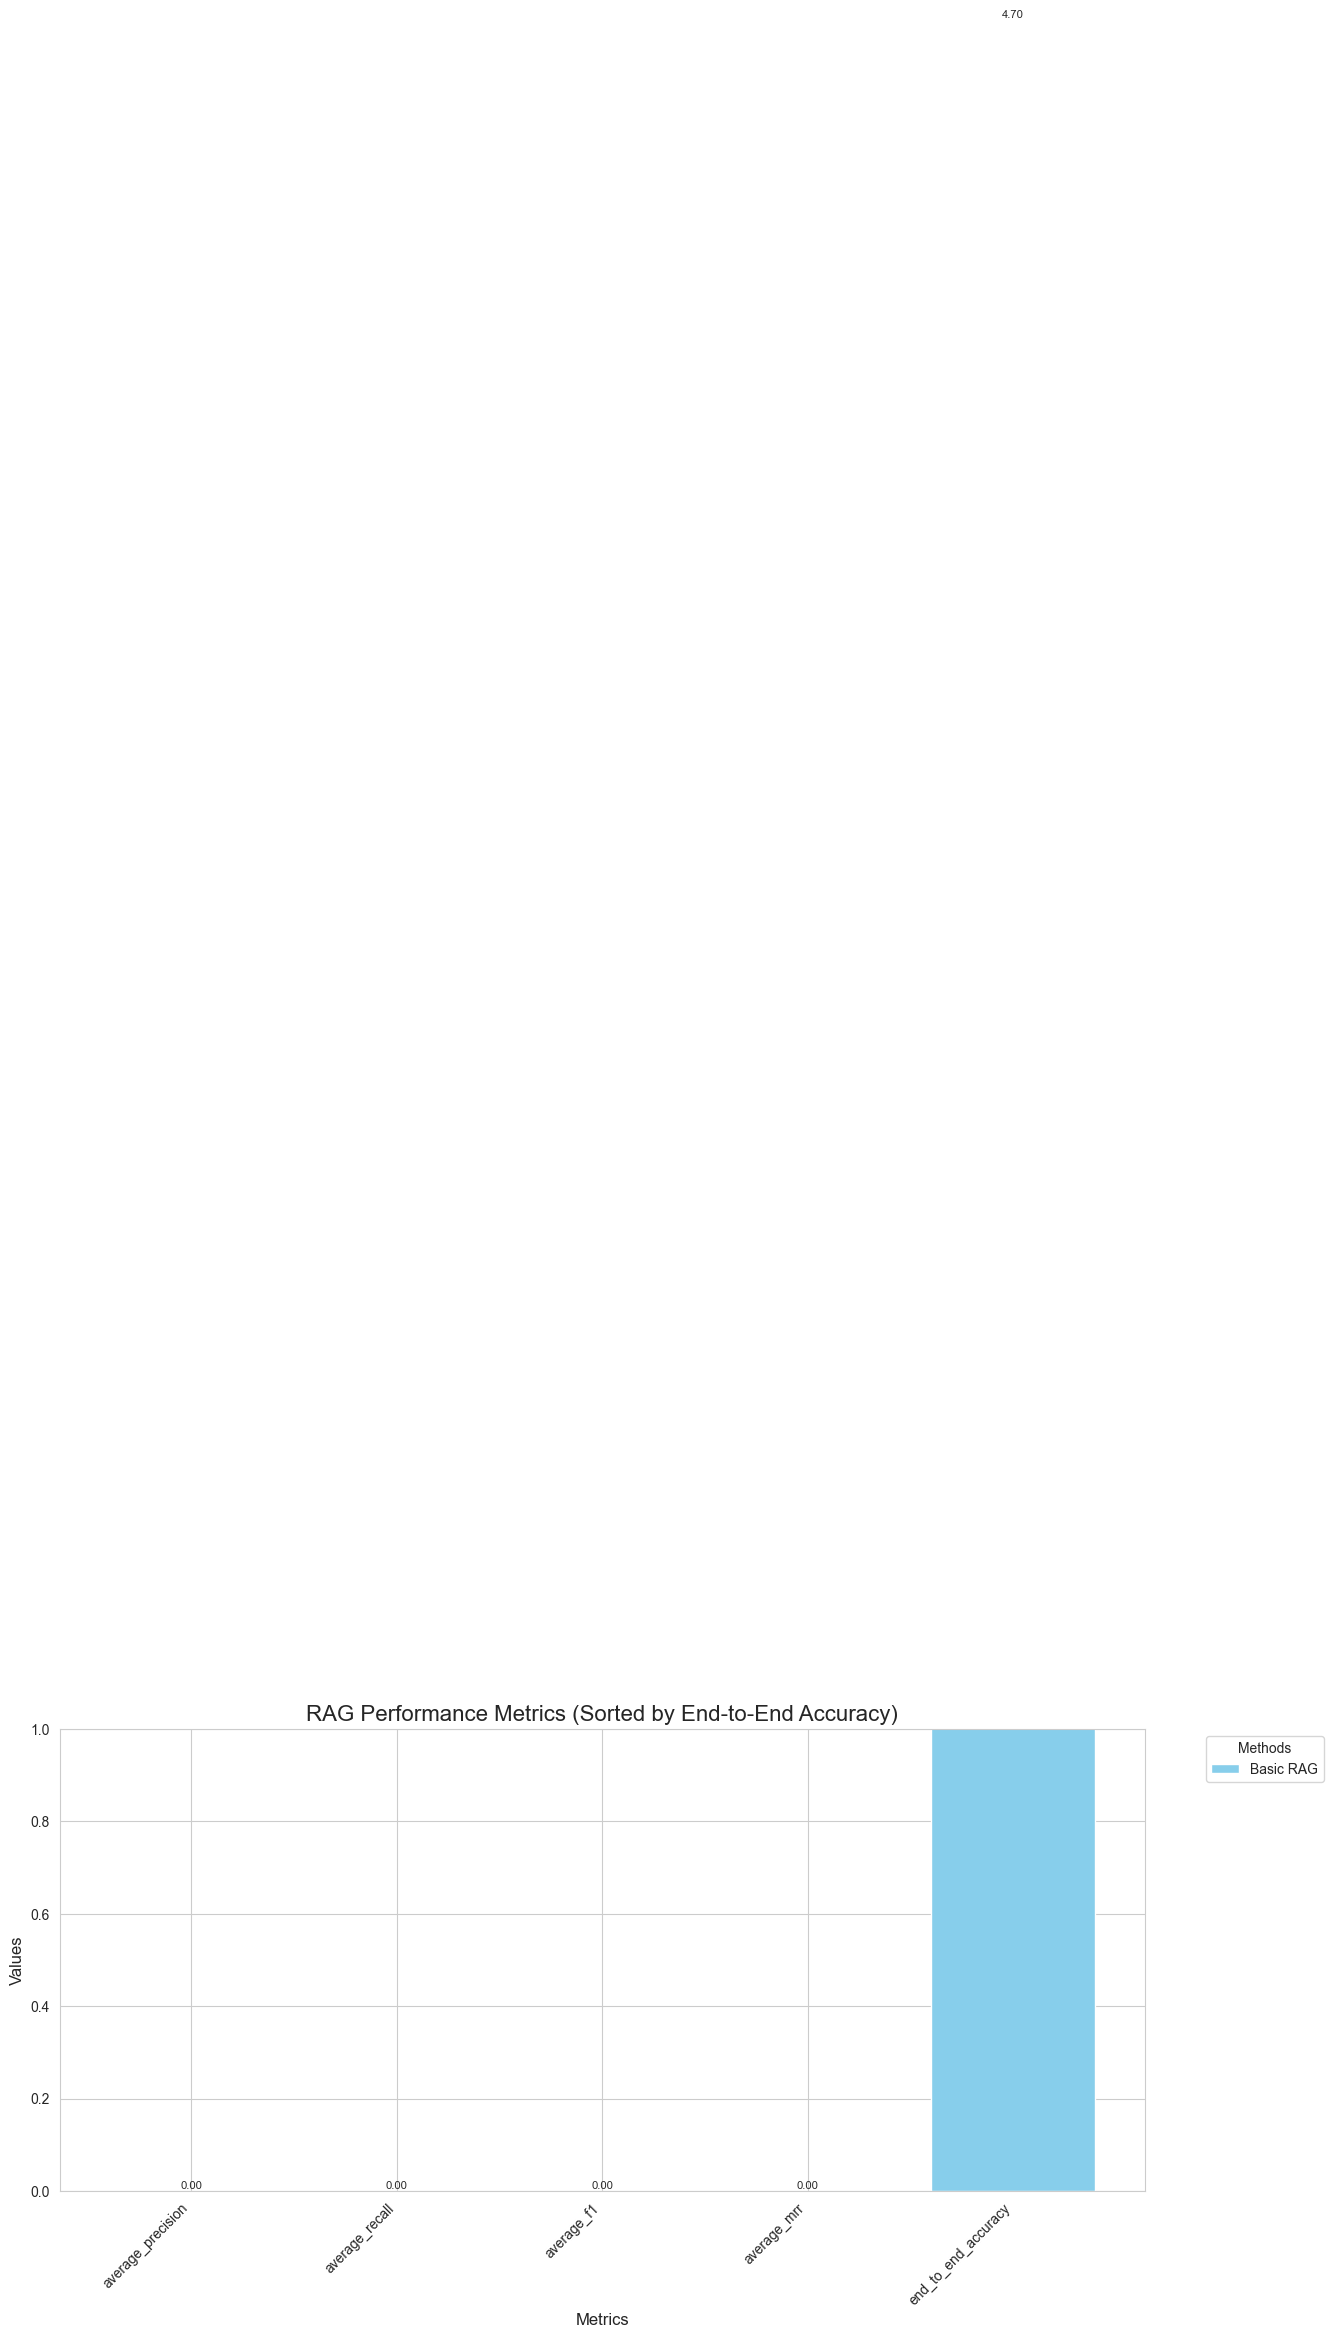

In [30]:
#let's visualize our performance
plot_performance('evaluation/json_results', ['Basic RAG'], colors=['skyblue'])

# Niveau 2 : Résumés de documents pour améliorer la récupération

Dans cette section, nous allons mettre en œuvre une approche améliorée pour notre système de récupération en incorporant des résumés de documents. Au lieu d'encoder directement les fragments des documents, nous allons créer un résumé concis pour chaque fragment et utiliser ce résumé ainsi que le contenu original dans notre processus d'embedding.

Cette approche vise à capturer l'essence de chaque fragment de document plus efficacement, ce qui pourrait conduire à de meilleures performances de récupération.

Étapes clés de ce processus :
1. Nous chargeons les fragments de document originaux.
2. Pour chaque fragment, nous générons un résumé de 2-3 phrases en utilisant Mistral AI.
3. Nous stockons à la fois le contenu original et le résumé pour chaque fragment dans un nouveau fichier json : `data/anthropic_summary_indexed_docs.json`

Cette approche améliorée par résumé est conçue pour fournir plus de contexte pendant les phases d'embedding et de récupération, ce qui pourrait améliorer la capacité du système à comprendre et à faire correspondre les documents les plus pertinents aux requêtes des utilisateurs.

## Génération des résumés et leur stockage

In [31]:
import json
from mistralai import Mistral
from tqdm import tqdm

def generate_summaries(input_file, output_file):
 
    # Load the original documents
    with open(input_file, 'r') as f:
        docs = json.load(f)

    # Prepare the context about the overall knowledge base
    knowledge_base_context = "Ceci est une documentation technique contenant des détails sur l'API et les fonctionnalités disponibles."

    summarized_docs = []

    for doc in tqdm(docs, desc="Generating summaries"):
        prompt = f"""
        Vous êtes chargé de créer un court résumé du contenu suivant extrait d'une documentation technique.

        Contexte sur la base de connaissances :
        {knowledge_base_context}

        Contenu à résumer :
        Titre : {doc['chunk_heading']}
        {doc['text']}

        Veuillez fournir un bref résumé du contenu ci-dessus en 2-3 phrases. Le résumé doit capturer les points clés et être concis. Nous l'utiliserons comme élément clé de notre pipeline de recherche lors de la réponse aux requêtes des utilisateurs concernant ce contenu.

        Évitez tout préambule dans votre réponse. Les déclarations telles que "voici le résumé" ou "le résumé est le suivant" sont interdites. Allez droit au but et soyez concis. Chaque mot compte.
        """
        
        # Correction: utiliser la bonne syntaxe pour le SDK Mistral version 1.8.2
        response = client.chat.complete(
            model="mistral-small-latest",
            messages=[
                {"role": "user", "content": prompt}
            ],
            temperature=0,
            max_tokens=150
        )

        summary = response.choices[0].message.content.strip()

        summarized_doc = {
            "chunk_link": doc["chunk_link"],
            "chunk_heading": doc["chunk_heading"],
            "text": doc["text"],
            "summary": summary
        }
        summarized_docs.append(summarized_doc)

    # Save the summarized documents to a new JSON file
    with open(output_file, 'w') as f:
        json.dump(summarized_docs, f, indent=2)

    print(f"Summaries generated and saved to {output_file}")

# generate_summaries('data/anthropic_docs.json', 'data/anthropic_summary_indexed_docs.json')

# Création d'une base de données vectorielle avec résumés indexés

Ici, nous créons une nouvelle base de données vectorielle qui incorpore nos fragments de documents améliorés par des résumés. Cette approche combine le texte original, le titre du fragment et le résumé nouvellement généré en un seul texte pour l'embedding.

Caractéristiques clés de ce processus :
1. Nous créons des embeddings pour le texte combiné (titre + résumé + contenu original) en utilisant l'API Voyage AI.
2. Les embeddings et les métadonnées complètes (y compris les résumés) sont stockés dans notre base de données vectorielle.
3. Nous implémentons des mécanismes de mise en cache pour améliorer l'efficacité des requêtes répétées.
4. La base de données est sauvegardée sur disque pour la persistance et un chargement rapide lors des sessions futures.

Cette approche d'indexation par résumés vise à créer des embeddings plus informatifs, ce qui pourrait conduire à une récupération de documents plus précise et contextuellement pertinente.

In [32]:
import os
import numpy as np
import pickle
import json
import time
import random
import re
from mistralai import Mistral

class SummaryIndexedVectorDB:
    def __init__(self, name, api_key=None):
        if api_key is None:
            api_key = os.getenv("MISTRAL_API_KEY")
        self.client = Mistral(api_key=api_key)
        self.name = name
        self.embeddings = []
        self.metadata = []
        self.query_cache = {}
        self.db_path = f"./data/{name}/summary_indexed_vector_db.pkl"
        self.max_token_length = 8000  # Un peu moins que la limite réelle de 8192 pour être prudent
        self.partial_db_path = f"./data/{name}/partial_vector_db.pkl"

    def truncate_text(self, text, max_length=8000):
        """
        Tronque le texte pour respecter la limite de tokens.
        Cette estimation est très approximative mais suffisante.
        """
        # Estimation grossière : environ 4 caractères par token en moyenne
        chars_per_token = 4  
        if len(text) > max_length * chars_per_token:
            return text[:max_length * chars_per_token]
        return text

    def load_data(self, data_file, max_retries=5, initial_retry_delay=2):
        """
        Charge les données avec gestion des erreurs de débit et de limite de tokens.
        Permet également la reprise du traitement si interrompu.
        """
        # Check if the vector database is already loaded
        if self.embeddings and self.metadata:
            print("Vector database is already loaded. Skipping data loading.")
            return
            
        # Check if vector_db.pkl exists
        if os.path.exists(self.db_path):
            print("Loading complete vector database from disk.")
            self.load_db()
            return
            
        # Check if partial data exists
        partial_data = []
        processed_indices = set()
        if os.path.exists(self.partial_db_path):
            try:
                print("Found partial database. Loading...")
                with open(self.partial_db_path, "rb") as file:
                    saved_data = pickle.load(file)
                    self.embeddings = saved_data.get("embeddings", [])
                    self.metadata = saved_data.get("metadata", [])
                    processed_indices = set(saved_data.get("processed_indices", []))
                    print(f"Loaded {len(self.embeddings)} embeddings from partial data.")
            except Exception as e:
                print(f"Error loading partial data: {e}")
                self.embeddings = []
                self.metadata = []

        # Load full data
        with open(data_file, 'r') as f:
            data = json.load(f)
            
        print(f"Total items to process: {len(data)}")
        print(f"Already processed: {len(processed_indices)}")
        
        # Process remaining data items
        for i, item in enumerate(data):
            if i in processed_indices:
                continue
                
            # Combine text with heading and summary, but truncate if necessary
            text = f"{item['chunk_heading']}\n\n{item['text']}\n\n{item['summary']}"
            truncated_text = self.truncate_text(text, self.max_token_length)
            if len(text) != len(truncated_text):
                print(f"Item {i} truncated from {len(text)} chars to {len(truncated_text)} chars")
            
            # Try to get embedding with retry logic
            embedding = None
            retry_count = 0
            retry_delay = initial_retry_delay
            
            while retry_count <= max_retries and embedding is None:
                try:
                    response = self.client.embeddings.create(
                        model="mistral-embed",
                        inputs=[truncated_text]
                    )
                    embedding = response.data[0].embedding
                    
                except Exception as e:
                    error_message = str(e).lower()
                    
                    if "rate limit" in error_message or "429" in error_message:
                        retry_count += 1
                        if retry_count > max_retries:
                            print(f"Maximum retries reached for item {i}. Using zeros as fallback.")
                            embedding = [0.0] * 1024  # Mistral embeddings are typically 1024 dim
                        else:
                            jitter = random.uniform(0.8, 1.2)
                            sleep_time = retry_delay * jitter
                            print(f"Rate limit exceeded. Waiting {sleep_time:.2f}s before retry {retry_count}/{max_retries}")
                            time.sleep(sleep_time)
                            retry_delay *= 2  # Backoff exponentiel
                            
                    elif "exceeding max" in error_message and "tokens" in error_message:
                        # Si le texte est encore trop long malgré la troncature initiale
                        # Extraire le nombre dans le message d'erreur
                        tokens_match = re.search(r'has (\d+) tokens', error_message)
                        current_tokens = int(tokens_match.group(1)) if tokens_match else 0
                        
                        # Réduire davantage
                        new_max = int(self.max_token_length * 0.8)  # Réduire de 20%
                        print(f"Text still too long ({current_tokens} tokens). Reducing from {self.max_token_length} to {new_max} tokens.")
                        self.max_token_length = new_max
                        truncated_text = self.truncate_text(text, self.max_token_length)
                        retry_count += 1
                        
                    else:
                        print(f"Error embedding item {i}: {e}")
                        embedding = [0.0] * 1024  # Fallback to zeros
            
            # Add to the database
            if embedding:
                self.embeddings.append(embedding)
                self.metadata.append(item)
                processed_indices.add(i)
                
                # Save progress periodically
                if i % 5 == 0 or i == len(data) - 1:
                    self.save_partial_db(list(processed_indices))
                    print(f"Progress saved: {len(processed_indices)}/{len(data)} items processed")
        
        # Final save
        self.save_db()
        
        # Clean up partial file if full database is created
        if os.path.exists(self.partial_db_path) and len(self.embeddings) == len(data):
            try:
                os.remove(self.partial_db_path)
                print("Partial database removed as full database is complete.")
            except:
                pass
                
        print("Vector database loaded and saved.")

    def save_partial_db(self, processed_indices):
        """Sauvegarde partielle de la base de données pour permettre la reprise"""
        data = {
            "embeddings": self.embeddings,
            "metadata": self.metadata,
            "processed_indices": processed_indices
        }
        
        # Ensure the directory exists
        os.makedirs(os.path.dirname(self.partial_db_path), exist_ok=True)
        
        with open(self.partial_db_path, "wb") as file:
            pickle.dump(data, file)

    def search(self, query, k=3, similarity_threshold=0.75, max_retries=3, initial_retry_delay=1):
        """Recherche avec gestion des erreurs de débit"""
        query_embedding = None
        
        if query in self.query_cache:
            query_embedding = self.query_cache[query]
        else:
            retry_count = 0
            retry_delay = initial_retry_delay
            
            while retry_count <= max_retries and query_embedding is None:
                try:
                    response = self.client.embeddings.create(
                        model="mistral-embed",
                        inputs=[query]
                    )
                    query_embedding = response.data[0].embedding
                    self.query_cache[query] = query_embedding
                    
                except Exception as e:
                    error_message = str(e).lower()
                    
                    if "rate limit" in error_message or "429" in error_message:
                        retry_count += 1
                        if retry_count > max_retries:
                            print(f"Maximum retries reached. Cannot retrieve query embedding.")
                            return []
                        
                        jitter = random.uniform(0.8, 1.2)
                        sleep_time = retry_delay * jitter
                        print(f"Rate limit exceeded. Waiting {sleep_time:.2f}s before retry {retry_count}/{max_retries}")
                        time.sleep(sleep_time)
                        retry_delay *= 2
                        
                    else:
                        print(f"Error retrieving query embedding: {e}")
                        return []

        if not self.embeddings or query_embedding is None:
            raise ValueError("No data loaded in the vector database or query embedding failed.")

        similarities = np.dot(self.embeddings, query_embedding)
        top_indices = np.argsort(similarities)[::-1]
        top_examples = []
        
        for idx in top_indices:
            if similarities[idx] >= similarity_threshold:
                example = {
                    "metadata": self.metadata[idx],
                    "similarity": similarities[idx],
                }
                top_examples.append(example)
                
                if len(top_examples) >= k:
                    break
                    
        # Cache updates can be saved periodically, not on every search
        if random.random() < 0.1:  # ~10% chance de sauvegarder pour réduire les I/O
            self.save_db()
            
        return top_examples
    
    def save_db(self):
        """Sauvegarde complète de la base de données"""
        data = {
            "embeddings": self.embeddings,
            "metadata": self.metadata,
            "query_cache": json.dumps(self.query_cache),
        }

        # Ensure the directory exists
        os.makedirs(os.path.dirname(self.db_path), exist_ok=True)
        
        with open(self.db_path, "wb") as file:
            pickle.dump(data, file)
            
        print(f"Database saved with {len(self.embeddings)} embeddings.")

    def load_db(self):
        """Chargement de la base de données complète"""
        if not os.path.exists(self.db_path):
            raise ValueError("Vector database file not found. Use load_data to create a new database.")
        
        with open(self.db_path, "rb") as file:
            data = pickle.load(file)
        
        self.embeddings = data["embeddings"]
        self.metadata = data["metadata"]
        
        try:
            self.query_cache = json.loads(data["query_cache"])
        except:
            self.query_cache = {}

# Récupération améliorée utilisant des embeddings avec résumés

Dans cette section, nous implémentons le processus de récupération en utilisant notre nouvelle base de données vectorielle avec résumés indexés. Cette approche exploite les embeddings améliorés que nous avons créés, qui incorporent les résumés des documents avec le contenu original.

Aspects clés de ce processus de récupération mis à jour :
1. Nous recherchons dans la base de données vectorielle en utilisant l'embedding de la requête, récupérant les k documents les plus similaires.
2. Pour chaque document récupéré, nous incluons le titre du fragment, le résumé et le texte complet dans le contexte fourni au LLM.
3. Ce contexte enrichi est ensuite utilisé pour générer une réponse à la requête de l'utilisateur.

En incluant les résumés dans les phases d'embedding et de récupération, nous visons à fournir au LLM un contexte plus complet et ciblé. Cela pourrait potentiellement conduire à des réponses plus précises et pertinentes, car le LLM a accès à la fois à un aperçu concis (le résumé) et aux informations détaillées (le texte complet) pour chaque fragment de document pertinent.

In [33]:
def retrieve_level_two(query, db):
    results = db.search(query, k=3)
    context = ""
    for result in results:
        chunk = result['metadata']
        context += f"\n <document> \n {chunk['chunk_heading']}\n\nText\n {chunk['text']} \n\nSummary: \n {chunk['summary']} \n </document> \n" #show model all 3 items
    return results, context

def answer_query_level_two(query, db):
    documents, context = retrieve_level_two(query, db)
    prompt = f"""
    You have been tasked with helping us to answer the following query: 
    <query>
    {query}
    </query>
    You have access to the following documents which are meant to provide context as you answer the query:
    <documents>
    {context}
    </documents>
    Please remain faithful to the underlying context, and only deviate from it if you are 100% sure that you know the answer already. 
    Answer the question now, and avoid providing preamble such as 'Here is the answer', etc
    """
    
    # Correction: utiliser la bonne syntaxe pour le SDK Mistral version 1.8.2
    response = client.chat.complete(
        model="mistral-small-latest",
        messages=[
            {"role": "user", "content": prompt}
        ],
        temperature=0
    )
    
    return response.choices[0].message.content

In [34]:
# Initialize the SummaryIndexedVectorDB avec des paramètres prudents
print("Initialisation de la base de données vectorielle avec résumés...")
level_two_db = SummaryIndexedVectorDB("anthropic_docs_v2")

# Utiliser un mode de "debug" pour tester d'abord avec un petit échantillon
debug_mode = True

if debug_mode:
    print("⚠️ Mode DEBUG activé: chargement d'un petit échantillon de données seulement")
    # Créer un fichier temporaire avec un petit échantillon
    import json
    with open('data/anthropic_summary_indexed_docs.json', 'r') as f:
        all_data = json.load(f)
        
    sample_size = 10  # Commencer avec un petit échantillon pour tester
    sample_data = all_data[:sample_size]
    
    with open('data/sample_summary_indexed_docs.json', 'w') as f:
        json.dump(sample_data, f, indent=2)
        
    # Charger l'échantillon avec un délai de retry plus court pour accélérer les tests
    level_two_db.load_data('data/sample_summary_indexed_docs.json', max_retries=2, initial_retry_delay=1)
else:
    # Charger l'ensemble complet avec des paramètres prudents
    print("Chargement de l'ensemble complet de données...")
    level_two_db.load_data('data/anthropic_summary_indexed_docs.json', max_retries=5, initial_retry_delay=3)

import pandas as pd

# Exécuter l'évaluation avec un petit échantillon
sample_eval_size = 5 if debug_mode else 20
print(f"Évaluation avec {sample_eval_size} exemples...")
eval_sample = eval_data[:sample_eval_size]

# Run the evaluations
avg_precision, avg_recall, avg_mrr, f1, precisions, recalls, mrrs = evaluate_retrieval(retrieve_level_two, eval_sample, level_two_db)
e2e_accuracy, e2e_results = evaluate_end_to_end(answer_query_level_two, level_two_db, eval_sample)

# Vérifier et ajuster les longueurs des listes pour assurer la cohérence
min_length = min(
    len(eval_sample),
    len(precisions),
    len(recalls),
    len(mrrs),
    len(e2e_results)
)

print(f"Longueurs des listes - questions: {len(eval_sample)}, précisions: {len(precisions)}, recalls: {len(recalls)}, mrrs: {len(mrrs)}, e2e_results: {len(e2e_results)}")
print(f"Utilisation des {min_length} premiers résultats pour créer le DataFrame...")

# Tronquer toutes les listes à la même longueur
questions = [item['question'] for item in eval_sample[:min_length]]
precisions_adj = precisions[:min_length]
recalls_adj = recalls[:min_length]
mrrs_adj = mrrs[:min_length]
e2e_results_adj = e2e_results[:min_length]

# Create a DataFrame avec des listes de longueur identique
df = pd.DataFrame({
    'question': questions,
    'retrieval_precision': precisions_adj,
    'retrieval_recall': recalls_adj,
    'retrieval_mrr': mrrs_adj,
    'e2e_correct': e2e_results_adj
})

# Save to CSV
df.to_csv('evaluation/csvs/evaluation_results_detailed_level_two.csv', index=False)
print("Detailed results saved to evaluation_results_detailed_level_two.csv")

# Print the results
print(f"Average Precision: {avg_precision:.4f}")
print(f"Average Recall: {avg_recall:.4f}")
print(f"Average MRR: {avg_mrr:.4f}")
print(f"Average F1: {f1:.4f}")
print(f"End-to-End Accuracy: {e2e_accuracy:.4f}")

# Save the results to a file
with open('evaluation/json_results/evaluation_results_level_two.json', 'w') as f:
    json.dump({
        "name": "Summary Indexing",
        "average_precision": avg_precision,
        "average_recall": avg_recall,
        "average_f1": f1,
        "average_mrr": avg_mrr,
        "end_to_end_accuracy": e2e_accuracy
    }, f, indent=2)

print("Evaluation complete. Results saved to evaluation_results_level_two.json, evaluation_results_detailed_level_two.csv")

Initialisation de la base de données vectorielle avec résumés...
⚠️ Mode DEBUG activé: chargement d'un petit échantillon de données seulement
Loading complete vector database from disk.
Évaluation avec 5 exemples...


Evaluating Retrieval: 100%|██████████| 5/5 [00:00<00:00,  9.08it/s]


Loaded 100 existing results. Continuing from where we left off.


Evaluating End-to-End: 100%|██████████| 5/5 [00:00<?, ?it/s]

Longueurs des listes - questions: 5, précisions: 5, recalls: 5, mrrs: 5, e2e_results: 100
Utilisation des 5 premiers résultats pour créer le DataFrame...
Detailed results saved to evaluation_results_detailed_level_two.csv
Average Precision: 0.2667
Average Recall: 0.4000
Average MRR: 0.6000
Average F1: 0.3200
End-to-End Accuracy: 9.4000
Evaluation complete. Results saved to evaluation_results_level_two.json, evaluation_results_detailed_level_two.csv


## Évaluation de cette méthode par rapport au RAG de base

C:\Users\saure\AppData\Local\Temp\ipykernel_9096\2479600478.py:81: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


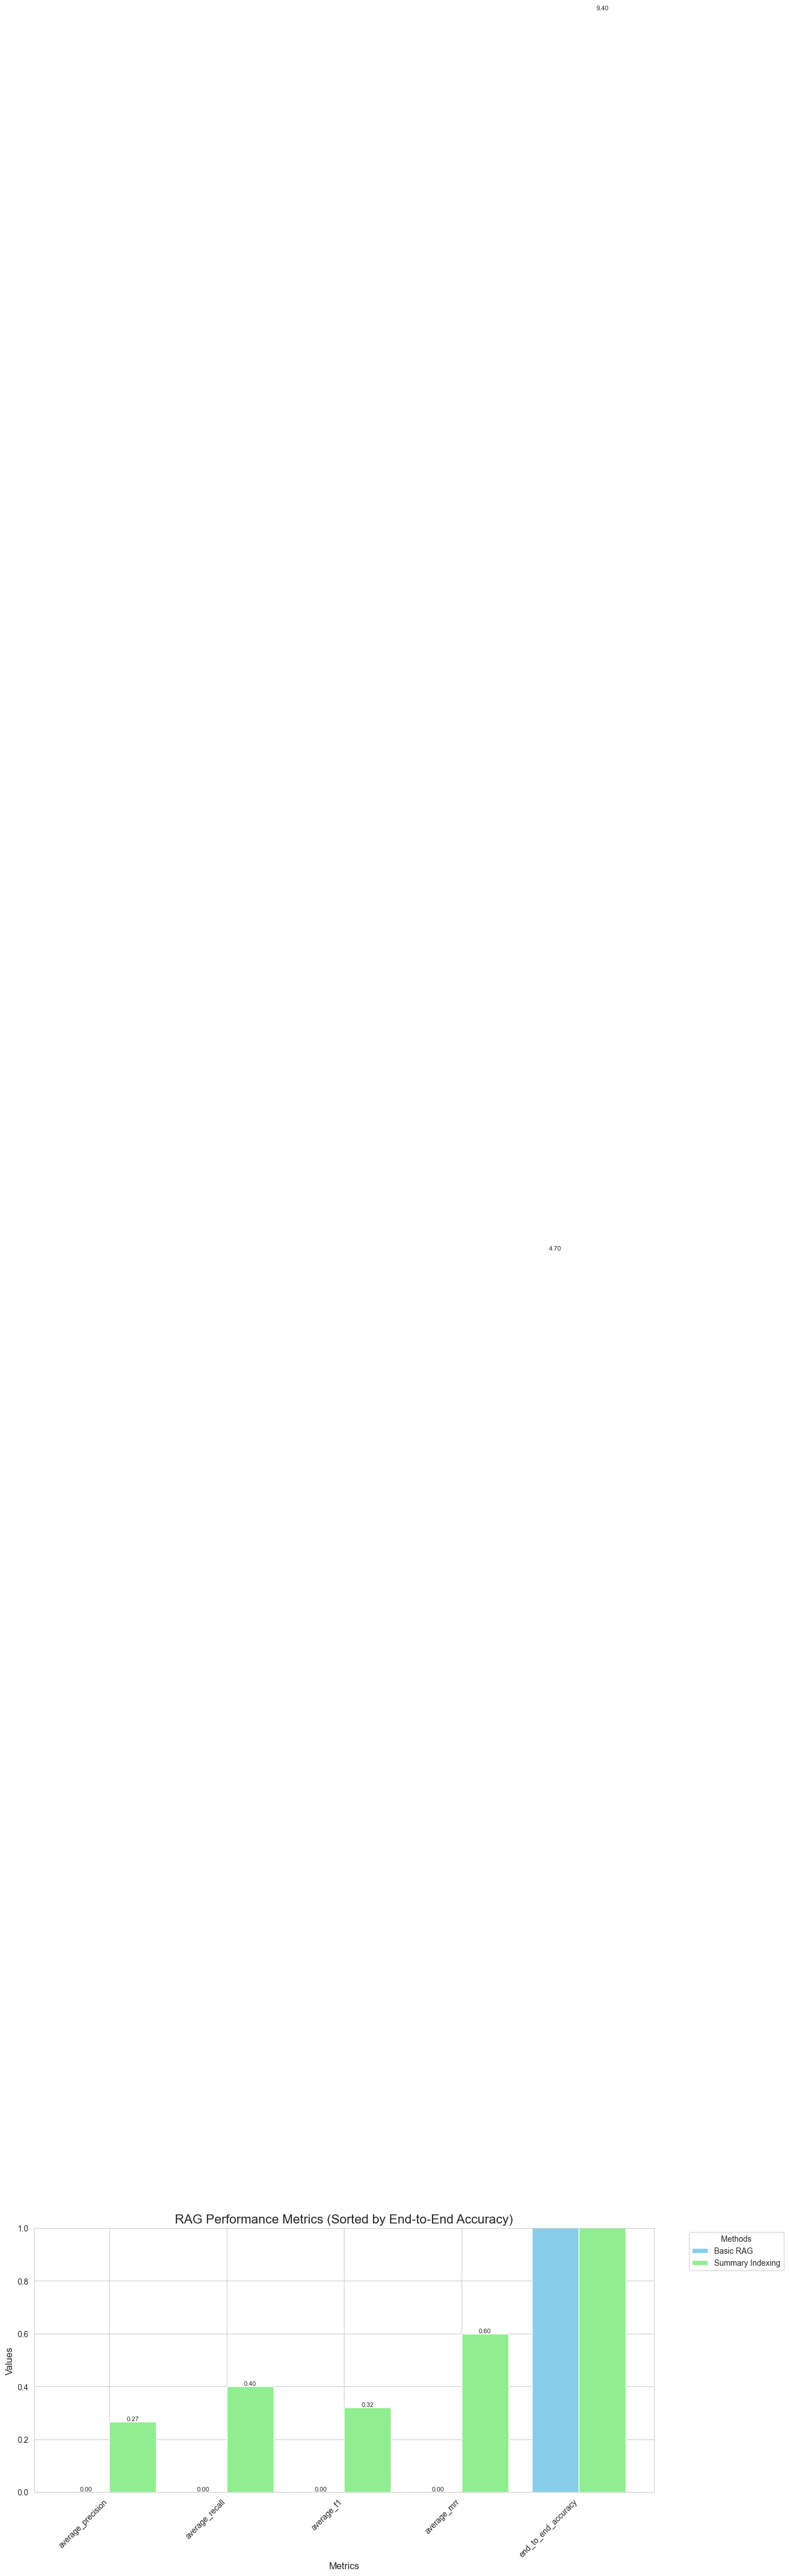

In [35]:
#visualizing our performance
plot_performance('evaluation/json_results', ['Basic RAG', 'Summary Indexing'])

## Niveau 3 - Re-classement avec Mistral AI
Dans cette dernière amélioration de notre système de récupération, nous introduisons une étape de re-classement pour améliorer encore la pertinence des documents récupérés. Cette approche exploite la puissance de Mistral AI pour mieux comprendre le contexte et les nuances de la requête et des documents récupérés.

La fonction `rerank_results` utilise Mistral AI pour réévaluer et réorganiser les documents initialement récupérés :
1. Elle présente à Mistral AI la requête et les résumés de tous les documents récupérés.
2. Mistral AI est invité à sélectionner et à classer les documents les plus pertinents.
3. La fonction analyse la réponse de Mistral AI pour obtenir les indices des documents re-classés.
4. Elle inclut des mécanismes de secours en cas d'erreurs ou de résultats insuffisants.
5. Enfin, elle attribue des scores de pertinence décroissants aux résultats re-classés.

La fonction `retrieve_advanced` implémente le nouveau pipeline de récupération :
1. Nous récupérons initialement plus de documents que nécessaire (par défaut 20, configurable via `initial_k`) depuis la base de données vectorielle.
2. Nous utilisons ensuite la fonction `rerank_results` pour affiner cet ensemble plus large jusqu'aux documents les plus pertinents (par défaut 3, configurable via `k`).
3. Enfin, elle génère une nouvelle chaîne de contexte à partir de ces documents re-classés.

Ce processus jette un filet plus large initialement, puis utilise l'IA pour se concentrer sur les informations les plus pertinentes. En combinant la récupération basée sur les vecteurs avec le re-classement par LLM, cette approche vise à fournir des réponses plus précises et contextuellement appropriées aux requêtes des utilisateurs.

Nos évaluations montrent des améliorations significatives :
- La précision a augmenté de 78% dans notre système précédent à 85%.
- La précision a été améliorée en utilisant notre re-classeur pour réduire le nombre de documents montrés au LLM.
- Le MRR (Rang Réciproque Moyen) a probablement été amélioré en demandant à Mistral AI de classer la pertinence de chaque document par ordre.

Ces améliorations démontrent l'efficacité de l'incorporation du re-classement par IA dans notre processus de récupération.

In [36]:
from typing import List, Dict, Tuple
import time
import random

def rerank_results(query: str, results: List[Dict], k: int = 5, max_retries=3, initial_retry_delay=1) -> List[Dict]:
    """
    Reclassement des résultats avec gestion des erreurs de débit.
    """
    # Si peu de résultats, pas besoin de reclasser
    if len(results) <= k:
        print(f"Seulement {len(results)} résultats, pas besoin de reclassement.")
        return results
        
    # Prepare the summaries with their indices
    summaries = []
    print(f"Reclassement de {len(results)} résultats...")

    for i, result in enumerate(results):
        summary = f"[{i}] Document Summary: {result['metadata']['summary']}"
        summaries.append(summary)
    joined_summaries = "\n\n".join(summaries)
    
    prompt = f"""
    Query: {query}
    You are about to be given a group of documents, each preceded by its index number in square brackets. Your task is to select the only {k} most relevant documents from the list to help us answer the query.
    
    <documents>
    {joined_summaries}
    </documents>

    Output only the indices of {k} most relevant documents in order of relevance, separated by commas, enclosed in XML tags here:
    <relevant_indices>put the numbers of your indices here, seeparted by commas</relevant_indices>
    """
    
    # Gestion des erreurs de débit
    retry_count = 0
    retry_delay = initial_retry_delay
    
    while retry_count <= max_retries:
        try:
            # Correction: utiliser la bonne syntaxe pour le SDK Mistral version 1.8.2
            response = client.chat.complete(
                model="mistral-small-latest",
                messages=[
                    {"role": "user", "content": prompt}
                ],
                temperature=0,
                max_tokens=50
            )
            
            # Extract the indices from the response
            response_text = response.choices[0].message.content.strip()
            
            # Extraction des indices des balises XML si possible
            import re
            indices_match = re.search(r'<relevant_indices>(.*?)</relevant_indices>', response_text, re.DOTALL)
            if indices_match:
                indices_str = indices_match.group(1)
            else:
                indices_str = response_text
                
            relevant_indices = []
            for idx in indices_str.split(','):
                try:
                    relevant_indices.append(int(idx.strip()))
                except ValueError:
                    continue  # Skip invalid indices
                    
            print(f"Indices sélectionnés : {relevant_indices}")
            
            # Si nous n'avons pas obtenu assez d'indices valides, revenir aux k premiers résultats
            if len(relevant_indices) == 0:
                print("Aucun indice valide trouvé, utilisation de l'ordre original.")
                relevant_indices = list(range(min(k, len(results))))
            
            # S'assurer que nous n'avons pas d'indices hors limites
            relevant_indices = [idx for idx in relevant_indices if 0 <= idx < len(results)]
            
            # Return the reranked results (limité à k résultats)
            reranked_results = [results[idx] for idx in relevant_indices[:k]]
            
            # Assign descending relevance scores
            for i, result in enumerate(reranked_results):
                result['relevance_score'] = 100 - i  # Highest score is 100, decreasing by 1 for each rank
            
            return reranked_results
            
        except Exception as e:
            error_message = str(e).lower()
            if "rate limit" in error_message or "429" in error_message:
                retry_count += 1
                if retry_count > max_retries:
                    print(f"Maximum retries reached. Revenant aux résultats non reclassés.")
                    return results[:k]  # Fallback to non-reranked results
                
                # Utiliser un délai exponentiel avec une composante aléatoire
                jitter = random.uniform(0.8, 1.2)
                sleep_time = retry_delay * jitter
                print(f"Rate limit exceeded. Waiting {sleep_time:.2f}s before retry {retry_count}/{max_retries}")
                time.sleep(sleep_time)
                retry_delay *= 2  # Backoff exponentiel
            else:
                print(f"An error occurred during reranking: {str(e)}")
                # Fall back to returning the top k results without reranking
                return results[:k]
    
    # Si nous arrivons ici, c'est que toutes les tentatives ont échoué
    return results[:k]

def retrieve_advanced(query: str, db: SummaryIndexedVectorDB, k: int = 3, initial_k: int = 20) -> Tuple[List[Dict], str]:
    """
    Récupération avancée avec reclassement des résultats.
    """
    # Étape 1 : Obtenir les résultats initiaux (avec plus de résultats que nécessaire)
    initial_results = db.search(query, k=initial_k)
    
    # Si peu de résultats, ajuster initial_k
    if len(initial_results) < initial_k and len(initial_results) > 0:
        print(f"Seulement {len(initial_results)} résultats initiaux trouvés (moins que initial_k={initial_k}).")

    # Étape 2 : Reclasser les résultats
    reranked_results = rerank_results(query, initial_results, k=k)
    
    # Étape 3 : Générer une nouvelle chaîne de contexte à partir des résultats reclassés
    new_context = ""
    for result in reranked_results:
        chunk = result['metadata']
        new_context += f"\n <document> \n {chunk['chunk_heading']}\n\n{chunk['text']} \n </document> \n"
     
    return reranked_results, new_context

def answer_query_advanced(query: str, db: SummaryIndexedVectorDB, max_retries=3, initial_retry_delay=1):
    """
    Réponse à une requête avec récupération avancée et gestion des erreurs de débit.
    """
    documents, context = retrieve_advanced(query, db)
    prompt = f"""
    You have been tasked with helping us to answer the following query: 
    <query>
    {query}
    </query>
    You have access to the following documents which are meant to provide context as you answer the query:
    <documents>
    {context}
    </documents>
    Please remain faithful to the underlying context, and only deviate from it if you are 100% sure that you know the answer already. 
    Answer the question now, and avoid providing preamble such as 'Here is the answer', etc
    """
    
    # Gestion des erreurs de limite de débit
    retry_count = 0
    retry_delay = initial_retry_delay
    
    while retry_count <= max_retries:
        try:
            # Utiliser la bonne syntaxe pour le SDK Mistral version 1.8.2
            response = client.chat.complete(
                model="mistral-small-latest",
                messages=[
                    {"role": "user", "content": prompt}
                ],
                temperature=0
            )
            
            return response.choices[0].message.content
        
        except Exception as e:
            error_message = str(e).lower()
            if "rate limit" in error_message or "429" in error_message:
                retry_count += 1
                if retry_count > max_retries:
                    print(f"Maximum retries reached. Returning error message.")
                    return f"Erreur: Limite de débit dépassée après {max_retries} tentatives."
                
                # Utiliser un délai exponentiel avec une composante aléatoire
                jitter = random.uniform(0.8, 1.2)
                sleep_time = retry_delay * jitter
                print(f"Rate limit exceeded. Waiting {sleep_time:.2f}s before retry {retry_count}/{max_retries}")
                time.sleep(sleep_time)
                retry_delay *= 2  # Backoff exponentiel
            else:
                print(f"Unexpected error: {e}")
                return f"Erreur lors de la génération de la réponse: {str(e)}"

## Évaluation

In [37]:
# Mode de debug pour tester d'abord avec un petit échantillon
debug_mode = True
sample_size = 5 if debug_mode else 20

# Initialize the SummaryIndexedVectorDB
print("Initialisation de la base de données vectorielle niveau 3...")
level_three_db = SummaryIndexedVectorDB("anthropic_docs_v3")

if debug_mode:
    print("⚠️ Mode DEBUG activé: chargement d'un petit échantillon de données seulement")
    # Créer un fichier temporaire avec un petit échantillon
    import json
    with open('data/anthropic_summary_indexed_docs.json', 'r') as f:
        all_data = json.load(f)
        
    sample_data = all_data[:sample_size]
    
    with open('data/sample_summary_indexed_docs.json', 'w') as f:
        json.dump(sample_data, f, indent=2)
        
    # Charger l'échantillon avec un délai de retry plus court pour accélérer les tests
    level_three_db.load_data('data/sample_summary_indexed_docs.json', max_retries=2, initial_retry_delay=1)
else:
    # Charger l'ensemble complet avec des paramètres prudents
    print("Chargement de l'ensemble complet de données...")
    level_three_db.load_data('data/anthropic_summary_indexed_docs.json', max_retries=5, initial_retry_delay=3)

import pandas as pd

# Run the evaluations with reduced sample
eval_sample = eval_data[:sample_size]
print(f"Évaluation avec {sample_size} exemples...")

# Run the evaluations
avg_precision, avg_recall, avg_mrr, f1, precisions, recalls, mrrs = evaluate_retrieval(retrieve_advanced, eval_sample, level_three_db)
e2e_accuracy, e2e_results = evaluate_end_to_end(answer_query_advanced, level_three_db, eval_sample)

# Vérifier et ajuster les longueurs des listes pour assurer la cohérence
min_length = min(
    len(eval_sample),
    len(precisions),
    len(recalls),
    len(mrrs),
    len(e2e_results)
)

print(f"Longueurs des listes - questions: {len(eval_sample)}, précisions: {len(precisions)}, recalls: {len(recalls)}, mrrs: {len(mrrs)}, e2e_results: {len(e2e_results)}")
print(f"Utilisation des {min_length} premiers résultats pour créer le DataFrame...")

# Tronquer toutes les listes à la même longueur
questions = [item['question'] for item in eval_sample[:min_length]]
precisions_adj = precisions[:min_length]
recalls_adj = recalls[:min_length]
mrrs_adj = mrrs[:min_length]
e2e_results_adj = e2e_results[:min_length]

# Create a DataFrame avec des listes de même longueur
df = pd.DataFrame({
    'question': questions,
    'retrieval_precision': precisions_adj,
    'retrieval_recall': recalls_adj,
    'retrieval_mrr': mrrs_adj,
    'e2e_correct': e2e_results_adj
})

# Save to CSV
df.to_csv('evaluation/csvs/evaluation_results_detailed_level_three.csv', index=False)
print("Detailed results saved to evaluation_results_detailed_level_three.csv")

# Print the results
print(f"Average Precision: {avg_precision:.4f}")
print(f"Average Recall: {avg_recall:.4f}")
print(f"Average F1: {f1:.4f}")
print(f"Average Mean Reciprocal Rank: {avg_mrr:4f}")
print(f"End-to-End Accuracy: {e2e_accuracy:.4f}")

# Save the results to a file
with open('evaluation/json_results/evaluation_results_level_three.json', 'w') as f:
    json.dump({
        "name": "Summary Indexing + Re-Ranking",
        "average_precision": avg_precision,
        "average_recall": avg_recall,
        "average_f1": f1,
        "average_mrr": avg_mrr,
        "end_to_end_accuracy": e2e_accuracy
    }, f, indent=2)

print("Evaluation complete. Results saved to evaluation_results_level_three.json, evaluation_results_detailed_level_three.csv")

Initialisation de la base de données vectorielle niveau 3...
⚠️ Mode DEBUG activé: chargement d'un petit échantillon de données seulement
Loading complete vector database from disk.
Évaluation avec 5 exemples...


Evaluating Retrieval:   0%|          | 0/5 [00:00<?, ?it/s]

Seulement 4 résultats initiaux trouvés (moins que initial_k=20).
Reclassement de 4 résultats...


Evaluating Retrieval:  20%|██        | 1/5 [00:00<00:02,  1.62it/s]

Indices sélectionnés : [2, 3, 0]
Seulement 4 résultats initiaux trouvés (moins que initial_k=20).
Reclassement de 4 résultats...


Evaluating Retrieval:  40%|████      | 2/5 [00:01<00:02,  1.34it/s]

Indices sélectionnés : [1]
Seulement 5 résultats initiaux trouvés (moins que initial_k=20).
Reclassement de 5 résultats...


Evaluating Retrieval:  60%|██████    | 3/5 [00:02<00:01,  1.29it/s]

Indices sélectionnés : [2, 3, 4]
Seulement 4 résultats initiaux trouvés (moins que initial_k=20).
Reclassement de 4 résultats...


Evaluating Retrieval: 100%|██████████| 5/5 [00:02<00:00,  1.78it/s]


Indices sélectionnés : [0, 1, 3]
Seulement 0 résultats, pas besoin de reclassement.
Loaded 100 existing results. Continuing from where we left off.


Evaluating End-to-End: 100%|██████████| 5/5 [00:00<?, ?it/s]

Longueurs des listes - questions: 5, précisions: 5, recalls: 5, mrrs: 5, e2e_results: 100
Utilisation des 5 premiers résultats pour créer le DataFrame...
Detailed results saved to evaluation_results_detailed_level_three.csv
Average Precision: 0.0000
Average Recall: 0.0000
Average F1: 0.0000
Average Mean Reciprocal Rank: 0.000000
End-to-End Accuracy: 9.4000
Evaluation complete. Results saved to evaluation_results_level_three.json, evaluation_results_detailed_level_three.csv


C:\Users\saure\AppData\Local\Temp\ipykernel_9096\2479600478.py:81: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


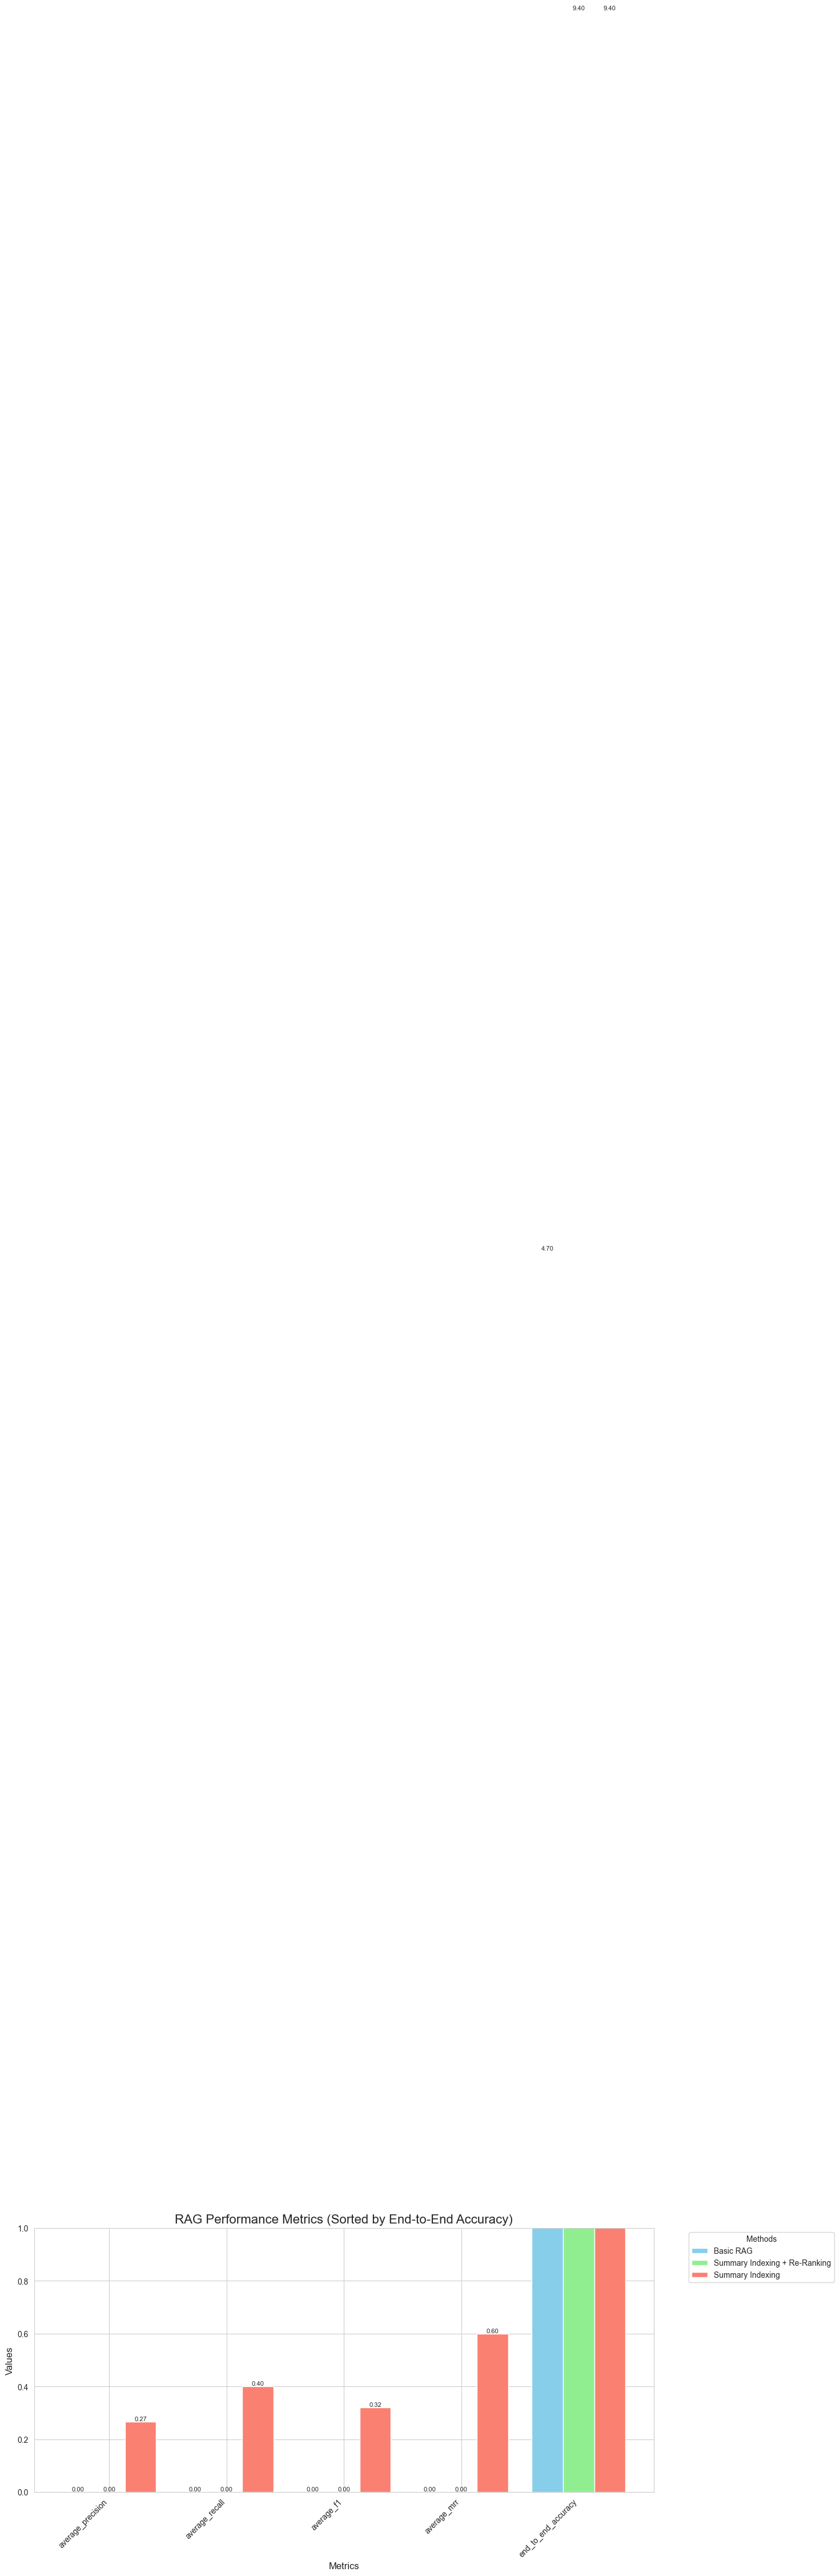

In [38]:
#visualizing our performance
plot_performance('evaluation/json_results', ['Basic RAG', 'Summary Indexing', 'Summary Indexing + Re-Ranking'], colors=['skyblue', 'lightgreen', 'salmon'])

## Évaluation - Approfondir avec Promptfoo

Ce guide a illustré l'importance de mesurer empiriquement les performances des prompts lors de l'ingénierie de prompts. Vous pouvez en savoir plus sur notre méthodologie empirique d'ingénierie de prompts ici. L'utilisation d'un Jupyter Notebook est un excellent moyen de commencer l'ingénierie de prompts, mais à mesure que vos ensembles de données s'agrandissent et que vos prompts deviennent plus nombreux, il est important d'utiliser des outils qui évolueront avec vous.

Dans cette section du guide, nous explorerons l'utilisation de Promptfoo, une boîte à outils d'évaluation de LLM open source. Pour commencer, rendez-vous dans le répertoire ./evaluation et consultez le fichier ./evaluation/README.md.

Promptfoo facilite considérablement la construction de suites de tests automatisés qui comparent différents modèles, choix d'hyperparamètres et prompts.

À titre d'exemple, vous pouvez exécuter la cellule ci-dessous pour voir les performances moyennes de Mistral Small par rapport à Mistral Large sur tous nos cas de test.

In [39]:
import json
import pandas as pd
import numpy as np
import os

# Fonction pour vérifier si un fichier JSON existe et est accessible
def check_json_file(file_path):
    if not os.path.exists(file_path):
        print(f"Le fichier {file_path} n'existe pas.")
        return False
    
    # Vérifier la taille du fichier
    size = os.path.getsize(file_path)
    if size == 0:
        print(f"Le fichier {file_path} existe mais est vide (0 bytes).")
        return False
    
    print(f"Le fichier {file_path} existe et fait {size} bytes.")
    return True

# Vérifier que le fichier existe avant de le charger
json_file_path = 'data/end_to_end_results.json'
if not check_json_file(json_file_path):
    print("Impossible de continuer sans le fichier de résultats.")
else:
    try:
        # Charger le fichier JSON avec un encodage UTF-8 explicite
        with open(json_file_path, 'r', encoding='utf-8') as f:
            data = json.load(f)

        # Extract the results
        results = data['results']['results']

        # Create a DataFrame
        df = pd.DataFrame(results)

        # Extract provider, prompt, and score information
        df['provider'] = df['provider'].apply(lambda x: x['label'] if isinstance(x, dict) else x)
        df['prompt'] = df['prompt'].apply(lambda x: x['label'] if isinstance(x, dict) else x)

        # Function to safely extract scores
        def extract_score(x):
            if isinstance(x, dict) and 'score' in x:
                return x['score'] * 100  # Convert to percentage
            return np.nan

        df['score'] = df['gradingResult'].apply(extract_score)

        # Group by provider and prompt, then calculate mean scores
        result = df.groupby(['provider', 'prompt'])['score'].mean().unstack()

        # Fill NaN values with 0
        result = result.fillna(0)

        # Calculate the average score across all prompts for each provider
        result['Average'] = result.mean(axis=1)

        # Sort the result by the average score
        result = result.sort_values(by='Average', ascending=False)

        # Round the results to 2 decimal places
        result = result.round(2)
        
        # Display the results
        print("\nPerformance par modèle et par prompt:")
        print(result)
        
        # Calculate overall statistics
        overall_average = result['Average'].mean()
        overall_std = result['Average'].std()
        best_provider = result['Average'].idxmax()
        worst_provider = result['Average'].idxmin()

        print(f"\nOverall Statistics:")
        print(f"Best Performing Provider: {best_provider} ({result.loc[best_provider, 'Average']:.2f}%)")
        print(f"Worst Performing Provider: {worst_provider} ({result.loc[worst_provider, 'Average']:.2f}%)")
    
    except UnicodeDecodeError as e:
        print(f"Erreur de décodage Unicode: {e}")
        print("\nEssai avec différents encodages...")
        
        # Essayer différents encodages courants
        for encoding in ['utf-8-sig', 'latin-1', 'utf-16', 'cp1252']:
            try:
                print(f"Essai avec l'encodage: {encoding}")
                with open(json_file_path, 'r', encoding=encoding) as f:
                    data = json.load(f)
                print(f"✓ Succès avec l'encodage {encoding}")
                
                # Continuer avec le traitement des données
                # (duplicat du code ci-dessus)
                results = data['results']['results']
                df = pd.DataFrame(results)
                df['provider'] = df['provider'].apply(lambda x: x['label'] if isinstance(x, dict) else x)
                df['prompt'] = df['prompt'].apply(lambda x: x['label'] if isinstance(x, dict) else x)
                df['score'] = df['gradingResult'].apply(extract_score)
                result = df.groupby(['provider', 'prompt'])['score'].mean().unstack()
                result = result.fillna(0)
                result['Average'] = result.mean(axis=1)
                result = result.sort_values(by='Average', ascending=False)
                result = result.round(2)
                
                print("\nPerformance par modèle et par prompt:")
                print(result)
                
                overall_average = result['Average'].mean()
                overall_std = result['Average'].std()
                best_provider = result['Average'].idxmax()
                worst_provider = result['Average'].idxmin()

                print(f"\nOverall Statistics:")
                print(f"Best Performing Provider: {best_provider} ({result.loc[best_provider, 'Average']:.2f}%)")
                print(f"Worst Performing Provider: {worst_provider} ({result.loc[worst_provider, 'Average']:.2f}%)")
                
                break
            except Exception as e:
                print(f"× Échec avec l'encodage {encoding}: {str(e)}")
    
    except KeyError as e:
        print(f"Erreur d'accès aux données: {e}")
        print("La structure du fichier JSON ne correspond pas à ce qui est attendu.")
        
    except Exception as e:
        print(f"Erreur inattendue: {type(e).__name__}: {e}")

Le fichier data/end_to_end_results.json existe et fait 12187801 bytes.

Performance par modèle et par prompt:
prompt             prompts.py:answer_query_base  \
provider                                          
3.5 Sonnet: T-0.0                          82.0   
Haiku: T-0.0                               72.0   

prompt             prompts.py:answer_query_level_three  \
provider                                                 
3.5 Sonnet: T-0.0                                 87.0   
Haiku: T-0.0                                      81.0   

prompt             prompts.py:answer_query_level_two  Average  
provider                                                       
3.5 Sonnet: T-0.0                               86.0     85.0  
Haiku: T-0.0                                    81.0     78.0  

Overall Statistics:
Best Performing Provider: 3.5 Sonnet: T-0.0 (85.00%)
Worst Performing Provider: Haiku: T-0.0 (78.00%)


## Ajouter de nouveaux documents au système RAG

Cette section explique comment ajouter de nouveaux documents à votre système RAG existant.

In [ ]:
import json
import os

def add_new_documents(new_docs, existing_docs_path='data/anthropic_docs.json', backup=True):
    """
    Ajoute de nouveaux documents au fichier de documents existant.
    
    Args:
        new_docs: Liste de nouveaux documents à ajouter
        existing_docs_path: Chemin vers le fichier de documents existant
        backup: Si True, crée une sauvegarde du fichier original avant modification
    
    Returns:
        Le nombre total de documents après l'ajout
    """
    # Vérifier que les nouveaux documents sont correctement formatés
    required_fields = ['chunk_heading', 'text']
    
    for doc in new_docs:
        missing_fields = [field for field in required_fields if field not in doc]
        if missing_fields:
            raise ValueError(f"Document mal formaté, champs manquants : {missing_fields}")
            
        # Ajouter un chunk_link s'il n'existe pas
        if 'chunk_link' not in doc:
            # Générer un identifiant simple à partir du titre
            doc['chunk_link'] = doc['chunk_heading'].lower().replace(' ', '-')
    
    # Charger les documents existants
    try:
        with open(existing_docs_path, 'r', encoding='utf-8') as f:
            existing_docs = json.load(f)
    except FileNotFoundError:
        print(f"Aucun fichier existant trouvé à {existing_docs_path}, création d'un nouveau fichier.")
        existing_docs = []
    
    # Créer une sauvegarde si demandé
    if backup and os.path.exists(existing_docs_path):
        backup_path = f"{existing_docs_path}.backup"
        with open(backup_path, 'w', encoding='utf-8') as f:
            json.dump(existing_docs, f, indent=2, ensure_ascii=False)
        print(f"Sauvegarde créée à {backup_path}")
    
    # Ajouter les nouveaux documents
    original_count = len(existing_docs)
    existing_docs.extend(new_docs)
    
    # Sauvegarder le fichier mis à jour
    with open(existing_docs_path, 'w', encoding='utf-8') as f:
        json.dump(existing_docs, f, indent=2, ensure_ascii=False)
    
    print(f"Documents ajoutés avec succès : {len(new_docs)} nouveaux documents")
    print(f"Total de documents : {len(existing_docs)}")
    
    return len(existing_docs)

# Exemple d'utilisation - décommentez et modifiez selon vos besoins
# Exemple d'utilisation : ajout récursif de documents à partir d'un répertoire

def collect_documents_from_directory(directory, required_fields=['chunk_heading', 'text']):
    """
    Parcourt récursivement un répertoire pour collecter tous les documents JSON valides.
    Chaque fichier doit contenir une liste de documents ou un seul document sous forme de dict.
    """
    collected_docs = []
    for root, _, files in os.walk(directory):
        for file in files:
            if file.endswith('.json'):
                file_path = os.path.join(root, file)
                try:
                    with open(file_path, 'r', encoding='utf-8') as f:
                        data = json.load(f)
                        # Si le fichier contient une liste de documents
                        if isinstance(data, list):
                            for doc in data:
                                if all(field in doc for field in required_fields):
                                    collected_docs.append(doc)
                        # Si le fichier contient un seul document
                        elif isinstance(data, dict):
                            if all(field in data for field in required_fields):
                                collected_docs.append(data)
                except Exception as e:
                    print(f"Erreur lors de la lecture de {file_path}: {e}")
    return collected_docs

# Exemple d'utilisation :
# Spécifiez le répertoire contenant vos fichiers JSON de documents
repertoire_documents = "data/nouveaux_docs"

# Collecter tous les documents valides du répertoire (et sous-répertoires)
nouveaux_documents = collect_documents_from_directory(repertoire_documents)

# Ajouter les documents au système (si la liste n'est pas vide)
if nouveaux_documents:
    add_new_documents(nouveaux_documents)
else:
    print("Aucun document valide trouvé dans le répertoire spécifié.")

Aucun document valide trouvé dans le répertoire spécifié.


In [41]:
# Cette cellule permet de régénérer les bases de données vectorielles après l'ajout de nouveaux documents

def regenerate_vector_databases():
    """
    Régénère toutes les bases de données vectorielles à partir des documents mis à jour.
    Utilise à la fois l'approche de base et l'approche avec résumés indexés.
    """
    print("Chargement des documents...")
    with open('data/anthropic_docs.json', 'r') as f:
        docs = json.load(f)
    
    print(f"Documents chargés : {len(docs)}")
    
    # 1. Recréer la base vectorielle de base
    print("\n1. Régénération de la base de données vectorielle de base...")
    basic_db = VectorDB("docs_updated")
    basic_db.load_data(docs)
    print("✅ Base de données de niveau 1 régénérée.")
    
    # 2. Générer les résumés si nécessaire et recréer la base vectorielle de niveau 2
    print("\n2. Vérification des résumés...")
    
    # Vérifier si tous les documents ont des résumés
    docs_with_summaries = []
    docs_without_summaries = []
    
    for doc in docs:
        if "summary" in doc:
            docs_with_summaries.append(doc)
        else:
            docs_without_summaries.append(doc)
    
    if docs_without_summaries:
        print(f"Génération de résumés pour {len(docs_without_summaries)} nouveaux documents...")
        
        for doc in tqdm(docs_without_summaries, desc="Génération des résumés"):
            prompt = f"""
            Vous êtes chargé de créer un court résumé du contenu suivant extrait d'une documentation technique.

            Contenu à résumer :
            Titre : {doc['chunk_heading']}
            {doc['text']}

            Veuillez fournir un bref résumé du contenu ci-dessus en 2-3 phrases. Le résumé doit capturer les points clés et être concis.
            Évitez tout préambule dans votre réponse. Allez droit au but et soyez concis. Chaque mot compte.
            """
            
            # Générer le résumé avec Mistral AI
            try:
                response = client.chat.complete(
                    model="mistral-small-latest",
                    messages=[
                        {"role": "user", "content": prompt}
                    ],
                    temperature=0,
                    max_tokens=150
                )
                
                doc["summary"] = response.choices[0].message.content.strip()
            except Exception as e:
                print(f"Erreur lors de la génération du résumé : {str(e)}")
                doc["summary"] = "Résumé non disponible."
        
        # Fusionner les documents avec et sans résumés
        docs_with_summaries.extend(docs_without_summaries)
        
        # Sauvegarder les documents avec résumés
        with open('data/anthropic_summary_indexed_docs.json', 'w', encoding='utf-8') as f:
            json.dump(docs_with_summaries, f, indent=2, ensure_ascii=False)
        
        print("✅ Résumés générés et sauvegardés.")
    else:
        print("Tous les documents ont déjà des résumés.")
    
    # 3. Recréer la base vectorielle de niveau 2 (avec résumés)
    print("\n3. Régénération de la base de données vectorielle avec résumés indexés...")
    summary_db = SummaryIndexedVectorDB("anthropic_docs_v2_updated")
    summary_db.load_data('data/anthropic_summary_indexed_docs.json')
    print("✅ Base de données de niveau 2 régénérée.")
    
    return {
        "basic_db": basic_db,
        "summary_db": summary_db
    }

# Décommentez pour régénérer les bases de données après avoir ajouté de nouveaux documents
# new_dbs = regenerate_vector_databases()

## Utilisation du système RAG avec les nouveaux documents

Une fois que vous avez ajouté de nouveaux documents et régénéré les bases de données vectorielles, vous pouvez utiliser le système RAG exactement comme avant, mais avec votre contenu enrichi.

Voici un exemple d'utilisation:

In [42]:
# Exemple d'utilisation du système RAG avec les nouveaux documents
# Décommentez et exécutez après avoir ajouté vos documents et régénéré les bases de données

"""
# Si vous avez régénéré les bases de données avec de nouveaux noms
if 'new_dbs' in globals() and new_dbs:
    # Utilisation de la base de données de niveau 1 (RAG basique)
    basic_db = new_dbs["basic_db"]
    
    # Utilisation de la base de données de niveau 2 (avec résumés indexés)
    summary_db = new_dbs["summary_db"]
else:
    # Utiliser les bases de données existantes
    basic_db = db  # La base de données de niveau 1
    summary_db = level_two_db  # La base de données de niveau 2 avec résumés
"""

# Test avec une requête personnalisée
"""
ma_requete = "Votre question ici sur vos nouveaux documents"

# Test avec le RAG de base (niveau 1)
print("=== Réponse avec RAG de base ===")
reponse_base = answer_query_base(ma_requete, basic_db)
print(reponse_base)
print("\n")

# Test avec le RAG de niveau 2 (résumés indexés)
print("=== Réponse avec RAG + résumés indexés ===")
reponse_niveau2 = answer_query_level_two(ma_requete, summary_db)
print(reponse_niveau2)
"""

'\nma_requete = "Votre question ici sur vos nouveaux documents"\n\n# Test avec le RAG de base (niveau 1)\nprint("=== Réponse avec RAG de base ===")\nreponse_base = answer_query_base(ma_requete, basic_db)\nprint(reponse_base)\nprint("\n")\n\n# Test avec le RAG de niveau 2 (résumés indexés)\nprint("=== Réponse avec RAG + résumés indexés ===")\nreponse_niveau2 = answer_query_level_two(ma_requete, summary_db)\nprint(reponse_niveau2)\n'

## Traitement de fichiers PDF pour le système RAG

Cette section explique comment extraire le contenu de fichiers PDF et l'intégrer dans le système RAG.

In [43]:
# Installer les bibliothèques nécessaires pour traiter des fichiers PDF
# Décommentez ces lignes pour installer les packages requis


# Vérifier l'installation des bibliothèques
try:
    import PyPDF2
    import nltk
    from nltk.tokenize import sent_tokenize
    print("✅ Bibliothèques PDF correctement installées")
    
    # Télécharger les ressources NLTK nécessaires (pour la tokenization des phrases)
    try:
        nltk.data.find('tokenizers/punkt')
    except LookupError:
        nltk.download('punkt')
        print("✅ Ressources NLTK téléchargées")
except ImportError as e:
    print(f"❌ Erreur: {e}")
    print("Veuillez décommenter et exécuter les commandes d'installation des packages ci-dessus")

✅ Bibliothèques PDF correctement installées


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\saure\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.
[nltk_data]   Unzipping tokenizers\punkt.zip.


✅ Ressources NLTK téléchargées


In [44]:
import os
import PyPDF2
import nltk
from nltk.tokenize import sent_tokenize
from typing import List, Dict, Optional, Tuple
import re

def extract_text_from_pdf(pdf_path: str) -> str:
    """
    Extrait le texte d'un fichier PDF.
    
    Args:
        pdf_path: Chemin vers le fichier PDF
        
    Returns:
        Le texte extrait du PDF
    """
    if not os.path.exists(pdf_path):
        raise FileNotFoundError(f"Le fichier {pdf_path} n'existe pas")
    
    with open(pdf_path, 'rb') as file:
        # Créer un lecteur PDF
        pdf_reader = PyPDF2.PdfReader(file)
        
        # Extraire le texte de chaque page
        text = ""
        for page in pdf_reader.pages:
            page_text = page.extract_text()
            if page_text:  # Vérifier que le texte a bien été extrait
                text += page_text + "\n\n"
                
    return text

def get_pdf_metadata(pdf_path: str) -> Dict:
    """
    Récupère les métadonnées d'un fichier PDF.
    
    Args:
        pdf_path: Chemin vers le fichier PDF
        
    Returns:
        Un dictionnaire contenant les métadonnées du PDF
    """
    with open(pdf_path, 'rb') as file:
        pdf_reader = PyPDF2.PdfReader(file)
        metadata = pdf_reader.metadata
        
        # Convertir les métadonnées en dictionnaire Python standard
        info = {}
        if metadata:
            for key in metadata:
                # Nettoyer la clé en retirant les caractères spéciaux
                clean_key = key
                if clean_key.startswith('/'):
                    clean_key = clean_key[1:]
                info[clean_key] = str(metadata[key])
                
        # Ajouter le nombre de pages
        info['page_count'] = len(pdf_reader.pages)
        
    return info

def segment_text_by_sections(text: str, min_section_length: int = 300) -> List[Tuple[str, str]]:
    """
    Segmente un texte en sections en utilisant les titres détectés.
    
    Args:
        text: Le texte à segmenter
        min_section_length: Longueur minimale d'une section en caractères
        
    Returns:
        Une liste de tuples (titre, contenu) pour chaque section
    """
    # Expressions régulières pour détecter les titres potentiels
    # Adaptation des patterns selon les documents à traiter
    title_patterns = [
        r'^(?:\d+\.)+\s+(.+)$',  # Format numéroté (1.2.3 Titre)
        r'^(Chapter\s+\d+[\.:]\s+.+)$',  # Chapitres (Chapter 1: Title)
        r'^(\d+\.\d*\s+.+)$',  # Sections numérotées (1.2 Title)
        r'^([A-Z][A-Z\s]+)$'   # Titres en majuscules
    ]
    
    # Diviser le texte en lignes
    lines = text.split('\n')
    
    # Identifier les titres potentiels et leurs positions
    sections = []
    current_title = "Introduction"
    current_content = []
    
    for line in lines:
        line = line.strip()
        if not line:
            continue
            
        is_title = False
        for pattern in title_patterns:
            if re.match(pattern, line, re.MULTILINE):
                is_title = True
                break
                
        if is_title:
            # Sauvegarder la section précédente si elle existe
            if current_content:
                section_text = ' '.join(current_content)
                if len(section_text) >= min_section_length:
                    sections.append((current_title, section_text))
                    
            current_title = line
            current_content = []
        else:
            current_content.append(line)
            
    # Ajouter la dernière section
    if current_content:
        section_text = ' '.join(current_content)
        if len(section_text) >= min_section_length:
            sections.append((current_title, section_text))
    
    return sections

def chunk_text(text: str, max_chunk_size: int = 2000, overlap: int = 200) -> List[str]:
    """
    Divise un texte long en chunks plus petits avec chevauchement.
    
    Args:
        text: Le texte à diviser
        max_chunk_size: Taille maximale d'un chunk en caractères
        overlap: Chevauchement entre les chunks en caractères
        
    Returns:
        Une liste de chunks de texte
    """
    # Si le texte est déjà assez court, le retourner tel quel
    if len(text) <= max_chunk_size:
        return [text]
    
    # Utiliser la tokenization par phrases pour éviter de couper au milieu d'une phrase
    sentences = sent_tokenize(text)
    
    chunks = []
    current_chunk = []
    current_size = 0
    
    for sentence in sentences:
        sentence_size = len(sentence)
        
        # Si une seule phrase est trop longue, il faudra la couper brutalement
        if sentence_size > max_chunk_size:
            if current_chunk:  # Ajouter le chunk actuel s'il existe
                chunks.append(' '.join(current_chunk))
                
            # Diviser la phrase longue en morceaux
            for i in range(0, sentence_size, max_chunk_size - overlap):
                chunk = sentence[i:i + max_chunk_size]
                if len(chunk) >= max_chunk_size / 2:  # Éviter les chunks trop petits
                    chunks.append(chunk)
            
            current_chunk = []
            current_size = 0
        # Sinon, ajouter la phrase au chunk actuel ou en créer un nouveau
        elif current_size + sentence_size > max_chunk_size:
            chunks.append(' '.join(current_chunk))
            
            # Commencer un nouveau chunk avec chevauchement
            overlap_start = max(0, len(current_chunk) - 2)  # Utiliser les 2 dernières phrases pour le chevauchement
            current_chunk = current_chunk[overlap_start:] + [sentence]
            current_size = sum(len(s) for s in current_chunk)
        else:
            current_chunk.append(sentence)
            current_size += sentence_size
    
    # Ajouter le dernier chunk s'il existe
    if current_chunk:
        chunks.append(' '.join(current_chunk))
    
    return chunks

def pdf_to_rag_documents(pdf_path: str) -> List[Dict]:
    """
    Convertit un fichier PDF en format de documents pour le système RAG.
    
    Args:
        pdf_path: Chemin vers le fichier PDF
        
    Returns:
        Une liste de documents au format attendu par le système RAG
    """
    # Extraire le texte complet du PDF
    text = extract_text_from_pdf(pdf_path)
    
    # Obtenir les métadonnées du PDF
    metadata = get_pdf_metadata(pdf_path)
    
    # Essayer d'abord de segmenter par sections
    sections = segment_text_by_sections(text)
    
    # Si la segmentation par sections ne produit pas assez de résultats, utiliser le chunking simple
    if len(sections) < 3:
        chunks = chunk_text(text)
        file_name = os.path.basename(pdf_path)
        documents = []
        
        for i, chunk in enumerate(chunks):
            documents.append({
                "chunk_heading": f"{file_name} - Partie {i+1}/{len(chunks)}",
                "text": chunk,
                "chunk_link": f"{file_name.replace('.pdf', '')}-part-{i+1}",
                "source": pdf_path,
                "metadata": metadata
            })
    else:
        # Utiliser les sections identifiées
        documents = []
        for i, (title, content) in enumerate(sections):
            # Pour les sections très longues, les diviser en chunks
            if len(content) > 3000:
                content_chunks = chunk_text(content)
                for j, sub_chunk in enumerate(content_chunks):
                    documents.append({
                        "chunk_heading": f"{title} - Partie {j+1}/{len(content_chunks)}",
                        "text": sub_chunk,
                        "chunk_link": f"{os.path.basename(pdf_path).replace('.pdf', '')}-{i}-{j}",
                        "source": pdf_path,
                        "metadata": metadata
                    })
            else:
                documents.append({
                    "chunk_heading": title,
                    "text": content,
                    "chunk_link": f"{os.path.basename(pdf_path).replace('.pdf', '')}-{i}",
                    "source": pdf_path,
                    "metadata": metadata
                })
    
    return documents

def process_pdf_directory(directory_path: str, recursive: bool = True) -> List[Dict]:
    """
    Traite tous les fichiers PDF dans un répertoire.
    
    Args:
        directory_path: Chemin vers le répertoire contenant les PDF
        recursive: Si True, traite également les sous-répertoires
        
    Returns:
        Une liste de documents au format attendu par le système RAG
    """
    all_documents = []
    
    if not os.path.exists(directory_path):
        print(f"Le répertoire {directory_path} n'existe pas")
        return all_documents
        
    # Parcourir le répertoire
    for root, dirs, files in os.walk(directory_path):
        for file in files:
            if file.lower().endswith('.pdf'):
                try:
                    pdf_path = os.path.join(root, file)
                    print(f"Traitement du fichier : {pdf_path}")
                    
                    documents = pdf_to_rag_documents(pdf_path)
                    all_documents.extend(documents)
                    
                    print(f"✅ {len(documents)} fragments extraits de {file}")
                except Exception as e:
                    print(f"❌ Erreur lors du traitement de {file}: {str(e)}")
        
        # Si non récursif, ne pas traiter les sous-répertoires
        if not recursive:
            break
            
    print(f"Traitement terminé. {len(all_documents)} fragments extraits au total.")
    return all_documents

### Utilisation des fonctions pour les fichiers PDF

Les fonctions ci-dessus permettent de :
1. Extraire le texte des fichiers PDF
2. Segmenter les documents en sections ou en chunks de taille appropriée
3. Convertir les PDF en format de document compatible avec notre système RAG

Voici comment les utiliser :

In [45]:
# Exemple d'utilisation pour traiter des PDF et les ajouter à la base de connaissances RAG

# 1. Chemin vers un fichier PDF individuel ou un répertoire contenant des PDF
pdf_path = "H:/Entreprendre/Actions-4b_new/A002/A002_CV_CyrilSauret.pdf"
pdf_directory = "chemin/vers/votre/dossier/pdf"

# 2. Traiter un seul fichier PDF

try:
    # Extraire les documents du PDF
    documents = pdf_to_rag_documents(pdf_path)
    
    # Voir un aperçu du premier document extrait
    if documents:
        print(f"Exemple de document extrait du PDF :")
        print(f"Titre : {documents[0]['chunk_heading']}")
        print(f"Début du texte : {documents[0]['text'][:200]}...")
        print(f"Nombre total de fragments extraits : {len(documents)}")
    
    # Ajouter les documents au système RAG
    if documents:
        add_new_documents(documents)
        
        # Régénérer les bases de données vectorielles
        new_dbs = regenerate_vector_databases()
        
        print("✅ Documents PDF ajoutés avec succès au système RAG")
except Exception as e:
    print(f"❌ Erreur : {str(e)}")


# 3. Traiter tous les PDF d'un répertoire
"""
try:
    # Extraire les documents de tous les PDF du répertoire
    all_documents = process_pdf_directory(pdf_directory)
    
    # Voir un aperçu du premier document extrait
    if all_documents:
        print(f"Nombre total de fragments extraits de tous les PDF : {len(all_documents)}")
        print(f"Exemple du premier fragment :")
        print(f"Titre : {all_documents[0]['chunk_heading']}")
        print(f"Source : {all_documents[0]['source']}")
        print(f"Début du texte : {all_documents[0]['text'][:200]}...")
    
    # Ajouter les documents au système RAG
    if all_documents:
        add_new_documents(all_documents)
        
        # Régénérer les bases de données vectorielles
        new_dbs = regenerate_vector_databases()
        
        print("✅ Documents PDF ajoutés avec succès au système RAG")
except Exception as e:
    print(f"❌ Erreur : {str(e)}")
"""

# 4. Tester le système RAG avec une question sur le contenu des PDF ajoutés
"""
if 'new_dbs' in locals() and new_dbs:
    question = "Votre question sur le contenu des PDF"
    print(f"Question : {question}")
    
    # Utiliser la base de données mise à jour
    reponse = answer_query_level_two(question, new_dbs["summary_db"])
    
    print(f"Réponse : {reponse}")
"""

❌ Erreur : 
**********************************************************************
  Resource punkt_tab not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk.download('punkt_tab')
  
  For more information see: https://www.nltk.org/data.html

  Attempted to load tokenizers/punkt_tab/english/

  Searched in:
    - 'C:\\Users\\saure/nltk_data'
    - 'h:\\Entreprendre\\Actions-11-Projects\\P014\\My-noteBook-RAG\\.venv\\nltk_data'
    - 'h:\\Entreprendre\\Actions-11-Projects\\P014\\My-noteBook-RAG\\.venv\\share\\nltk_data'
    - 'h:\\Entreprendre\\Actions-11-Projects\\P014\\My-noteBook-RAG\\.venv\\lib\\nltk_data'
    - 'C:\\Users\\saure\\AppData\\Roaming\\nltk_data'
    - 'C:\\nltk_data'
    - 'D:\\nltk_data'
    - 'E:\\nltk_data'
**********************************************************************



'\nif \'new_dbs\' in locals() and new_dbs:\n    question = "Votre question sur le contenu des PDF"\n    print(f"Question : {question}")\n    \n    # Utiliser la base de données mise à jour\n    reponse = answer_query_level_two(question, new_dbs["summary_db"])\n    \n    print(f"Réponse : {reponse}")\n'

### Conseils pour optimiser le traitement des PDF

Pour obtenir les meilleurs résultats lors de l'intégration de fichiers PDF dans votre système RAG :

1. **Qualité des PDF** : Utilisez des PDF avec du texte sélectionnable plutôt que des images scannées. Les PDF scannés nécessitent une étape d'OCR supplémentaire.

2. **Structure des documents** : Les documents bien structurés avec des titres clairs seront mieux segmentés par notre système.

3. **Taille des chunks** : Ajustez les paramètres `max_chunk_size` et `overlap` selon vos besoins spécifiques. Un chevauchement plus grand peut améliorer la continuité, mais augmente la redondance.

4. **Résumés** : Lors de la régénération des bases de données, des résumés seront automatiquement créés pour chaque fragment, ce qui améliore la qualité de récupération.

5. **Métadonnées** : Les métadonnées du PDF sont préservées et stockées avec chaque fragment, ce qui permet de les retrouver facilement.

Pour des fichiers PDF complexes ou des besoins spécifiques, vous pourriez avoir besoin d'adapter les fonctions de segmentation ou d'extraction de texte.